In [2]:
import datetime, calendar, glob, os

import pickle as pkl
import geopandas as gpd
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import properscoring as ps
import scipy.stats as stats
import seaborn as sns

from ipywidgets import *
from matplotlib import cm
from matplotlib_scalebar.scalebar import ScaleBar
from scipy.integrate import quad
from scipy.stats import multivariate_normal, norm
from sklearn.neighbors import KernelDensity
from statsmodels.distributions.empirical_distribution import ECDF
from matplotlib.transforms import ScaledTranslation
from numpy.lib.stride_tricks import sliding_window_view

from functional_utils import (_fDepth, 
                              _fQuantile, 
                              _confidence_intervals_from_fDepth, 
                              _confidence_intervals_from_eCDF)

from loading_utils import (_process_wind_metadata,
                           _process_testing_curves,
                           _process_testing_forecasts,
                           _process_training_curves,
                           _process_traning_forecasts)

from scores_utils import *

plt.rcParams["legend.handlelength"] = 1
plt.rcParams["legend.handleheight"] = 1.125
plt.rcParams["font.family"]         = "Avenir"

path_to_fDepth = "/Users/Guille/Desktop/dynamic_update/functional_forecast_dynamic_update/fDepth"
path_to_data   = "/Users/Guille/Desktop/dynamic_update/data"
path_to_images = "/Users/Guille/Desktop/dynamic_update/images"

# Loading color palette
palette_ = pd.read_csv(path_to_data + "/palette.csv")

# Loading Texas map
TX_ = gpd.read_file(path_to_data + "/maps/TX/State.shp")

In [3]:
print(palette_)

      miro      ibm
0  #013396  #648FFF
1  #B1C06E  #785EF0
2  #056534  #DC267F
3  #F80202  #FE6100
4  #FDD906  #FFB000
5  #FCF795      NaN
6  #CCEDFF      NaN
7  #FDD60B      NaN
8  #FCE9D0      NaN


# Historical random curves and day-ahead forecasts

In [4]:
T = 288
resource = 'solar'

# Load 2017 data as training set
with open(path_to_data + f"/linear_preprocessed_{resource}_2017.pkl", 'rb') as f:
    _data = pkl.load(f)

assets_tr_ = _data["assets"]
F_tr_      = _data["observations"]
E_tr_      = _data["forecasts"]
print(assets_tr_.shape, F_tr_.shape, E_tr_.shape)

# Reshape to day x interval x asset format
F_tr_ = F_tr_.reshape(int(F_tr_.shape[0]/T), T, F_tr_.shape[1])
E_tr_ = E_tr_.reshape(int(E_tr_.shape[0]/T), T, E_tr_.shape[1])
print(F_tr_.shape, E_tr_.shape)

# Load 2018 data as testing set
with open(path_to_data + f"/linear_preprocessed_{resource}_2018.pkl", 'rb') as f:
    _data = pkl.load(f)

assets_ts_ = _data["assets"]
F_ts_      = _data["observations"]
E_ts_      = _data["forecasts"]
print(assets_ts_.shape, F_ts_.shape, E_ts_.shape)

# Reshape to day x interval x asset format
F_ts_ = F_ts_.reshape(int(F_ts_.shape[0]/T), T, F_ts_.shape[1])
E_ts_ = E_ts_.reshape(int(E_ts_.shape[0]/T), T, E_ts_.shape[1])
print(F_ts_.shape, E_ts_.shape)

# Short testing set with training set order
order  = {v: i for i, v in enumerate(assets_tr_)}
idx_   = np.argsort([order[x] for x in assets_ts_])
F_ts_  = F_ts_[:, :, idx_]
E_ts_  = E_ts_[:, :, idx_]
print(F_ts_.shape, E_ts_.shape)

# From generation to capacity factor
p_tr_ = np.max(np.max(F_tr_, axis = 0), axis = 0)
p_ts_ = np.max(np.max(F_ts_, axis = 0), axis = 0)
print(p_tr_.shape, p_ts_.shape)

E_tr_ /= np.tile(p_tr_, (E_tr_.shape[0], E_tr_.shape[1], 1))
E_ts_ /= np.tile(p_ts_, (E_ts_.shape[0], E_ts_.shape[1], 1))
print(E_tr_.min(), E_tr_.max())
print(E_ts_.min(), E_ts_.max())

# No possible a capacity factor is larger than 1 or smaller than 0
E_tr_[E_tr_ > 1.] = 1.
E_tr_[E_tr_ < 0.] = 0.
E_ts_[E_ts_ > 1.] = 1.
E_ts_[E_ts_ < 0.] = 0.

# Format training set from day x interval x asset to [day * asset] x interval
E_ts_lin_ = E_ts_.copy()
E_tr_lin_ = np.concatenate([E_tr_[..., k] for k in range(E_tr_.shape[2])], axis = 0)
print(E_tr_lin_.shape)
print(E_ts_lin_.shape)

(211,) (104544, 211) (104544, 211)
(363, 288, 211) (363, 288, 211)
(211,) (104832, 211) (104832, 211)
(364, 288, 211) (364, 288, 211)
(364, 288, 211) (364, 288, 211)
(211,) (211,)
-8.225737043183879e-17 1.1666666178190028
-5.384514867794431e-17 2.1269094668054778
(76593, 288)
(364, 288, 211)


In [5]:
# Load 2017 data as training set
with open(path_to_data + f"/preprocessed_{resource}_2017.pkl", 'rb') as f:
    _data = pkl.load(f)

assets_tr_ = _data["assets"]
x_tr_      = _data["locations"]
dates_tr_  = _data["dates"]
F_tr_      = _data["observations"]
E_tr_      = _data["forecasts"]
print(assets_tr_.shape, x_tr_.shape, dates_tr_.shape, F_tr_.shape, E_tr_.shape)

# Reshape to day x interval x asset format
F_tr_ = F_tr_.reshape(int(F_tr_.shape[0]/T), T, F_tr_.shape[1])
E_tr_ = E_tr_.reshape(int(E_tr_.shape[0]/T), T, E_tr_.shape[1])
T_tr_ = dates_tr_.reshape(int(dates_tr_.shape[0]/T), T)
print(F_tr_.shape, E_tr_.shape, T_tr_.shape)

# Load 2018 data as testing set
with open(path_to_data + f"/preprocessed_{resource}_2018.pkl", 'rb') as f:
    _data = pkl.load(f)

assets_ts_ = _data["assets"]
x_ts_      = _data["locations"]
dates_ts_  = _data["dates"]
F_ts_      = _data["observations"]
E_ts_      = _data["forecasts"]
print(assets_ts_.shape, x_ts_.shape, dates_ts_.shape, F_ts_.shape, E_ts_.shape)

# Reshape to day x interval x asset format
F_ts_ = F_ts_.reshape(int(F_ts_.shape[0]/T), T, F_ts_.shape[1])
E_ts_ = E_ts_.reshape(int(E_ts_.shape[0]/T), T, E_ts_.shape[1])
T_ts_ = dates_ts_.reshape(int(dates_ts_.shape[0]/T), T)
print(F_ts_.shape, E_ts_.shape, T_ts_.shape)

# Short testing set with training set order
order      = {v: i for i, v in enumerate(assets_tr_)}
idx_       = np.argsort([order[x] for x in assets_ts_])
assets_ts_ = assets_ts_[idx_]
x_ts_      = x_ts_[idx_]
F_ts_      = F_ts_[:, :, idx_]
E_ts_      = E_ts_[:, :, idx_]
print(F_ts_.shape, E_ts_.shape, T_ts_.shape)

# From generation to capacity factor
p_tr_ = np.max(np.max(F_tr_, axis = 0), axis = 0)
p_ts_ = np.max(np.max(F_ts_, axis = 0), axis = 0)
print(p_tr_.shape, p_ts_.shape)

F_tr_ /= np.tile(p_tr_, (F_tr_.shape[0], F_tr_.shape[1], 1))
E_tr_ /= np.tile(p_tr_, (E_tr_.shape[0], E_tr_.shape[1], 1))
F_ts_ /= np.tile(p_ts_, (F_ts_.shape[0], F_ts_.shape[1], 1))
E_ts_ /= np.tile(p_ts_, (E_ts_.shape[0], E_ts_.shape[1], 1))
print(F_tr_.min(), F_tr_.max())
print(E_tr_.min(), E_tr_.max())
print(F_ts_.min(), F_ts_.max())
print(E_ts_.min(), E_ts_.max())

# No possible a capacity factor is larger than 1 or smaller than 0
F_tr_[F_tr_ > 1.] = 1.
F_tr_[F_tr_ < 0.] = 0.
F_ts_[F_ts_ > 1.] = 1.
F_ts_[F_ts_ < 0.] = 0.
E_tr_[E_tr_ > 1.] = 1.
E_tr_[E_tr_ < 0.] = 0.
E_ts_[E_ts_ > 1.] = 1.
E_ts_[E_ts_ < 0.] = 0.

# Format training set from day x interval x asset to [day * asset] x interval
T_tr_      = np.concatenate([T_tr_ for k in range(assets_tr_.shape[0])], axis = 0)
assets_tr_ = np.concatenate([np.tile(assets_tr_[k], (F_tr_.shape[0], 1)) for k in range(assets_tr_.shape[0])], axis = 0)
x_tr_      = np.concatenate([np.tile(x_tr_[k, :], (F_tr_.shape[0], 1)) for k in range(x_tr_.shape[0])], axis = 0)
F_tr_      = np.concatenate([F_tr_[..., k] for k in range(F_tr_.shape[2])], axis = 0)
E_tr_      = np.concatenate([E_tr_[..., k] for k in range(E_tr_.shape[2])], axis = 0)
print(x_tr_.shape, assets_tr_.shape, F_tr_.shape, E_tr_.shape, T_tr_.shape)
print(x_ts_.shape, assets_ts_.shape, F_ts_.shape, E_ts_.shape, T_ts_.shape)

t_tr_ = np.array([datetime.datetime.strptime(t_tr, "%Y-%m-%d %H:%M:%S").timetuple().tm_yday 
                  for t_tr in T_tr_[:, 0]]) - 1
t_ts_ = np.array([datetime.datetime.strptime(t_ts, "%Y-%m-%d %H:%M:%S").timetuple().tm_yday 
                  for t_ts in T_ts_[:, 0]]) - 1
print(t_tr_.shape, t_ts_.shape)

(211,) (211, 2) (104544,) (104544, 211) (104544, 211)
(363, 288, 211) (363, 288, 211) (363, 288)
(211,) (211, 2) (104832,) (104832, 211) (104832, 211)
(364, 288, 211) (364, 288, 211) (364, 288)
(364, 288, 211) (364, 288, 211) (364, 288)
(211,) (211,)
0.0 1.0
0.0 1.1666666178190028
0.0 1.0
0.0 2.1269094668054778
(76593, 2) (76593, 1) (76593, 288) (76593, 288) (76593, 288)
(211, 2) (211,) (364, 288, 211) (364, 288, 211) (364, 288)
(76593,) (364,)


In [6]:
dt = 5
T  = 288
subsample = 12

dt_ = np.linspace(0, T*dt - dt, T)
dx_ = pd.to_datetime(pd.DataFrame({"time": dt_}).time, unit = "m").dt.strftime("%H:%M").to_numpy()
print(dt_.shape, dx_.shape)

print(F_tr_.shape, F_ts_.shape, E_tr_.shape, E_ts_.shape)
print(E_tr_lin_.shape, E_ts_lin_.shape)


# Ensure the length is divisible by subsample
T_p = T - (T % subsample)
print(T, T_p, T % subsample)

F_tr_p_ = F_tr_[:, :T_p]
F_ts_p_ = F_ts_[:, :T_p, :]
E_tr_p_ = E_tr_[:, :T_p]
E_ts_p_ = E_ts_[:, :T_p, :]
E_tr_lin_p_ = E_tr_lin_[:, :T_p]
E_ts_lin_p_ = E_ts_lin_[:, :T_p, :]
print(F_tr_p_.shape, F_ts_p_.shape, E_tr_p_.shape, E_ts_p_.shape)
print(E_tr_lin_p_.shape, E_ts_lin_p_.shape)

#h // k, k, w // k, k
F_tr_p_ = F_tr_p_.reshape(F_tr_p_.shape[0], 
                          F_tr_p_.shape[1]//subsample, 
                          subsample).mean(axis = -1)

F_ts_p_ = np.swapaxes(F_ts_p_, 1, 2)
F_ts_p_ = F_ts_p_.reshape(F_ts_p_.shape[0], 
                          F_ts_p_.shape[1], 
                          F_ts_p_.shape[2]//subsample, 
                          subsample).mean(axis = -1)
F_ts_p_ = np.swapaxes(F_ts_p_, 2, 1)

E_tr_p_ = E_tr_p_.reshape(E_tr_p_.shape[0], 
                          E_tr_p_.shape[1]//subsample, 
                          subsample).mean(axis = -1)

E_ts_p_ = np.swapaxes(E_ts_p_, 1, 2)
E_ts_p_ = E_ts_p_.reshape(E_ts_p_.shape[0], 
                          E_ts_p_.shape[1], 
                          E_ts_p_.shape[2]//subsample, 
                          subsample).mean(axis = -1)
E_ts_p_ = np.swapaxes(E_ts_p_, 2, 1)

E_tr_lin_p_ = E_tr_lin_p_.reshape(E_tr_lin_p_.shape[0], 
                                  E_tr_lin_p_.shape[1]//subsample, 
                                  subsample).mean(axis = -1)

E_ts_lin_p_ = np.swapaxes(E_ts_lin_p_, 1, 2)
E_ts_lin_p_ = E_ts_lin_p_.reshape(E_ts_lin_p_.shape[0], 
                                  E_ts_lin_p_.shape[1], 
                                  E_ts_lin_p_.shape[2]//subsample, 
                                  subsample).mean(axis = -1)
E_ts_lin_p_ = np.swapaxes(E_ts_lin_p_, 2, 1)

dt_p_ = dt_[::subsample]
dx_p_ = dx_[::subsample]

T_tr_p_ = T_tr_[:, ::subsample]
T_ts_p_ = T_ts_[:, ::subsample]

(288,) (288,)
(76593, 288) (364, 288, 211) (76593, 288) (364, 288, 211)
(76593, 288) (364, 288, 211)
288 288 0
(76593, 288) (364, 288, 211) (76593, 288) (364, 288, 211)
(76593, 288) (364, 288, 211)


In [20]:
params_ = pd.read_csv(path_to_data + f'/inter_{resource}_dynamic_update_param.csv', 
                      index_col = 0)

params_.columns = params_.columns.astype(int)

# Functional kNNs dynamic update

In [9]:
# Calculate weighted (w_) distance between X_ and x_
def _euclidian_dist(X_, x_, w_ = []):
    if len(w_) == 0:
        w_ = np.ones(x_.shape)
    w_ = w_ / w_.sum()
    d_ = np.zeros((X_.shape[0],))
    for i in range(X_.shape[0]):
        d_[i] = w_.T @ (X_[i, :] - x_) ** 2
    return d_

# Radial Basis function kernel based on distance (d_)
def _rbf_kernel(d_, length_scale):
    w_ = np.exp(-d_ / length_scale)
    return w_  # /w_.sum()

def _inv_dist(d_, length_scale):
    w_ = 1.0 / (d_ + length_scale)
    return w_  # /w_.sum()

# Define exponential growth function
def _exponential_growth(tau_, growth_rate, scale = 12*5):
    return np.exp(np.log(0.5)*tau_/(growth_rate*scale))

# Define exponential decay function
def _exponential_decay(s_, decay_rate, scale = 12*5):
    return np.exp(np.log(0.5)*s_/(decay_rate*scale))    

def _logistic(x_, k):
    return 1. - 1.0 / (1.0 + np.exp(np.log(999) * x_ / (k*60/2)))

# Linear Inverse Exponential function
def _LIE(s_, nu, trust_rate, k = 2.5, alpha = 1., scale = 5*12):
    #x_ = x_ - T*5 + nu*5*12
    s_ = s_ + nu*scale
    x_ = k*s_/(nu*5*12 - 5)
    y_ = np.where(x_ > 0, -x_, -alpha*(np.exp(x_) - 1))
    y_ = (y_ + k)/(k + alpha)
    return trust_rate*y_

def _haversine_dist(x_1_, x_2_):
    """
    Calculate the distance between two points on Earth using the Haversine formula.

    Args:
        x_1_ (float): Longitude and latitude of the first point in degrees.
        x_2_ (float): Longitude and latitude of the second point in degrees.

    Returns:
        float: Distance between the two points in kilometers.
    """
    R = 6371  # Radius of Earth in kilometers

    dlat_ = np.deg2rad(x_2_[:, 1]) - np.deg2rad(x_1_[1])
    dlon_ = np.deg2rad(x_2_[:, 0]) - np.deg2rad(x_1_[0])

    theta = (np.sin(dlat_ / 2) ** 2
             + np.cos(np.deg2rad(x_1_[1]))
             * np.cos(np.deg2rad(x_2_[:, 1]))
             * np.sin(dlon_ / 2) ** 2)

    return 2.0 * R * np.arcsin(np.sqrt(theta))

# Periodic distance to rank samples by day of the year
def _periodic_dist(d, gamma, 
                   day_to_degree = 360/365, 
                   degree_to_rad = np.pi/180):
    return np.sin(0.5*day_to_degree*(d - gamma)*degree_to_rad)**2

# Define a function to calculate quantiles
def _KDE_quantile(_KDE, q_, x_min=0.0, x_max=1.0, n_samples=1000):
    """
    Calculates the quantile for a given probability using KDE.

    Parameters:
    _KDE: Kernel density estimate object (e.g., from scipy.stats.gaussian_kde).
    q:    Probability value (between 0 and 1) for which to calculate the quantile.

    Returns:
    The quantile value.
    """

    # Calculate CDF
    x_ = np.linspace(x_min, x_max, n_samples)
    # z_ = np.exp(_KDE.score_samples(x_[:, np.newaxis]))
    w_ = np.cumsum(np.exp(_KDE.score_samples(x_[:, np.newaxis])))
    # Normalize CDF
    w_ /= w_[-1]

    return np.interp(np.array(q_), w_, x_), np.interp(1.0 - np.array(q_), w_, x_)

# Silverman's Rule
def _silverman_rule(x_):
    IQR = np.percentile(x_, 75) - np.percentile(x_, 25)
    return 0.9 * min(np.std(x_), IQR / 1.34) * x_.shape[0] ** (-1 / 5)

# Filtering scenarios when they are above the upper threshold or below the lower threshold
def _scenario_filtering(W_, d_h_, d_p_, gamma, xi, kappa_min, kappa_max):

    sigma  = 0
    idx_spatial_  = None
    idx_temporal_ = None
    # Filter by similarity
    idx_          = np.arange(d_p_.shape[0], dtype = int)
    w_            = np.min(W_, axis = 0)
    idx_neigbors_ = idx_[w_ >= xi]
    idx_final_    = idx_neigbors_.copy()

    if idx_neigbors_.shape[0] > kappa_max:

        # Filter by temporal distance
        idx_temporal_ = idx_[d_p_ <= gamma]
        idx_temporal_ = np.intersect1d(idx_neigbors_, idx_temporal_)
        if idx_.shape[0] < kappa_min:
            idx_temporal_ = idx_neigbors_.copy()

        # Filter by spatial distance
        idx_spatial_rank_ = np.argsort(d_h_[idx_temporal_])
        idx_spatial_      = idx_temporal_[idx_spatial_rank_][:kappa_max]
        if idx_spatial_.shape[0] < kappa_min:
            idx_spatial_ = idx_temporal_.copy()
        else:
            sigma = d_h_[idx_spatial_].max()

        idx_final_ = idx_spatial_.copy()

    if idx_neigbors_.shape[0] < kappa_min:
        # Increase similarity threshold
        idx_final_ = idx_[w_ >= np.sort(w_)[::-1][kappa_min - 1]]
        
    return w_, idx_neigbors_, idx_temporal_, idx_spatial_, idx_final_, sigma

def _fknn_forecast_dynamic_update(F_tr_, E_tr_, x_tr_, t_tr_, dt_, f_, e_, x_, t_ts, T, 
                                  forget_rate_f  = 1.,
                                  forget_rate_e  = .5,
                                  length_scale_f = .1,
                                  length_scale_e = .75,
                                  lookup_rate    = .05,
                                  trust_rate     = 0.0175,
                                  nu             = 340,
                                  gamma          = 30,
                                  xi             = 0.99,
                                  kappa_min      = 500,
                                  kappa_max      = 1500,
                                  idx_hours_     = False):

    # Get constants
    t    = f_.shape[0]
    dt   = (dt_[t + 1] - dt_[t])
    T    = dt_[-1] + dt

    tau_ = dt_[:t]
    s_   = dt_[t:]

    F_tr_p_   = F_tr_[:, :t]
    F_tr_hat_ = F_tr_[:, t:]
    E_tr_hat_ = E_tr_[:, t:]

    # phi: importance weights based on past time distance
    phi_ = _exponential_growth(tau_[::-1], forget_rate_f)
    # psi: importance weights based on past and future time distance
    psi_1_ = _exponential_growth(tau_[::-1], forget_rate_e)
    psi_2_ = _exponential_decay(s_ - dt_[t], lookup_rate)
    psi_   = np.concatenate([psi_1_, psi_2_], axis = 0)
    #eta_ = _logistic(s_ - t*5 - nu*60., trust_rate)
    eta_ = _LIE(s_[::-1] - T, nu, trust_rate)
    
    # Only for solar
    phi_[~idx_hours_[:t]] = 0.
    psi_[~idx_hours_]     = 0.

    # d: Euclidean distance between samples weighted by importance weights
    d_f_ = _euclidian_dist(F_tr_p_, f_, w_ = phi_)
    d_e_ = _euclidian_dist(E_tr_, e_, w_ = psi_)
    d_h_ = _haversine_dist(x_, x_tr_)
    d_p_ = _periodic_dist(t_tr_, t_ts)
    # print(x_tr_.shape, x_ts_.shape, d_s_.shape)
    # print(t_tr_.shape, t_ts_.shape, d_t_.shape)

    # w: normalized weights distance across observations based exponential link function
    w_f_ = _rbf_kernel(d_f_, length_scale_f)
    w_e_ = _rbf_kernel(d_e_, length_scale_e)
    W_   = np.stack([w_f_, w_e_])

    Gamma = _periodic_dist(t_ts, t_ts + gamma)

    (w_, 
    idx_1_, 
    idx_2_, 
    idx_3_, 
    idx_4_, 
    sigma) = _scenario_filtering(W_, d_h_, d_p_, Gamma, xi, kappa_min, kappa_max)

    # Fuse scenarios with day-ahead forecasts
    M_ = np.zeros((idx_4_.shape[0], eta_.shape[0]))
    for i, j in zip(idx_4_, range(idx_4_.shape[0])):
        M_[j, :] = F_tr_hat_[i, :]*(1. - eta_) + E_tr_hat_[i, :]*eta_

    _meta = {
        'phi': phi_,
        'psi': psi_,
        'eta': eta_,
        'd_f': d_f_,
        'd_e': d_e_,
        'd_h': d_h_,
        'd_p': d_p_,
        'w_f': w_f_,
        'w_e': w_e_,
        'w': w_,
        'idx_1': idx_1_,
        'idx_2': idx_2_,
        'idx_3': idx_3_,
        'idx_4': idx_4_,
        'xi': xi,
        't_ts': t_ts,
        'Gamma': Gamma,
        'sigma': sigma,
    }

    return _meta, M_

a = 30
d = 150
t = 12 * 12
file_name = f"{resource}-{a}-{d}-{t}"
print(file_name)

f_     = F_ts_[d, :t, a]
e_lin_ = E_ts_lin_[d, :, a]
e_     = E_ts_[d, :, a]
x_     = x_ts_[a, :]
time   = t_ts_[d]
f_hat_ = F_ts_[d, t:, a]

# Filter solar hours with loading solar set
idx_days_  = np.absolute(t_tr_ - d) < 7
idx_hours_ = np.sum(F_tr_[idx_days_, :], axis = 0) + np.sum(E_tr_[idx_days_, :], axis = 0) > 1.

_meta, M_ = _fknn_forecast_dynamic_update(F_tr_, E_tr_lin_, x_tr_, t_tr_, dt_, f_, e_lin_, x_, time, T,
                                          forget_rate_f  = 0.0625,
                                          forget_rate_e  = 0.5,
                                          lookup_rate    = 20.,
                                          length_scale_f = 0.025,
                                          length_scale_e = 0.1,
                                          trust_rate     = 0.3,
                                          nu             = 4,
                                          xi             = 0.8,
                                          gamma          = 30,
                                          kappa_min      = 50,
                                          kappa_max      = 150, 
                                          idx_hours_     = idx_hours_)

print(assets_ts_[a], T_ts_[d, t])

solar-30-150-144
Cottonwood Bayou 2018-05-31 12:00:00


In [13]:

a = 30
d = 150
t_p = 12 * (12//subsample)
file_name = f"{resource}-{a}-{d}-{t_p}"
print(file_name)

f_p_     = F_ts_p_[d, :t_p, a]
e_lin_p_ = E_ts_lin_p_[d, :, a]
e_p_     = E_ts_p_[d, :, a]
f_hat_p_ = F_ts_p_[d, t_p:, a]

x_   = x_ts_[a, :]
time = t_ts_[d]

# Filter solar hours with loading solar set
idx_days_  = np.absolute(t_tr_ - d) < 7
idx_hours_ = np.sum(F_tr_p_[idx_days_, :], axis = 0) + np.sum(E_tr_p_[idx_days_, :], axis = 0) > 1.

_meta_p, M_p_ = _fknn_forecast_dynamic_update(F_tr_p_, E_tr_lin_p_, 
                                              x_tr_, t_tr_, dt_p_, 
                                              f_p_, e_lin_p_, x_, time, T_p,
                                              forget_rate_f  = 0.0625,
                                              forget_rate_e  = 0.5,
                                              lookup_rate    = 20.,
                                              length_scale_f = 0.025,
                                              length_scale_e = 0.1,
                                              trust_rate     = 0.3,
                                              nu             = 4,
                                              xi             = 0.8,
                                              gamma          = 30,
                                              kappa_min      = 50,
                                              kappa_max      = 150, 
                                              idx_hours_     = idx_hours_)

print(assets_ts_[a], T_ts_p_[d, t_p])

solar-30-150-12
Cottonwood Bayou 2018-05-31 12:00:00


# Visualization Utils

(288,) (144,) (144,)
(144,) (144,) (288,)


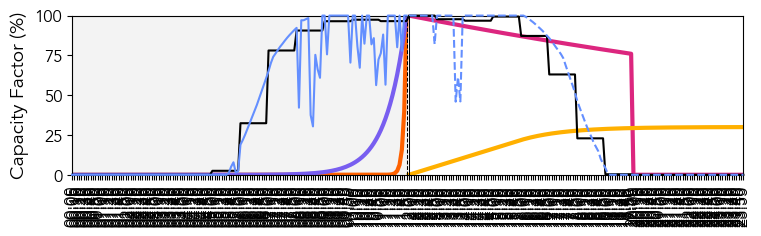

(24,) (12,) (12,)
(12,) (12,) (24,)


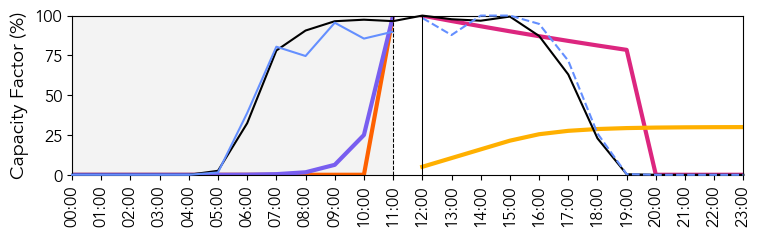

In [17]:
def _plot_forecast_parameters(_ax, f_, e_, f_hat_, phi_, psi_, eta_, dx_, dt_, t,
                              labels_1 = False,
                              labels_2 = False):

    tau_ = dt_[:t]
    s_   = dt_[t:]
    print(dt_.shape, tau_.shape, s_.shape)

    print(f_.shape, f_hat_.shape, e_.shape)

    _ax.plot(tau_, 100.0 * f_, 
             c=palette_.loc[0, "ibm"], 
             label="CF (actual)" if labels_1 else None, 
             lw=1.5, 
             zorder=5, 
             clip_on = False)

    _ax.plot(s_, 100.0 * f_hat_, 
             c=palette_.loc[0, "ibm"], 
             lw=1.5, 
             ls="--", 
             zorder=5, 
             clip_on = False)

    _ax.plot(dt_, 100.0 * e_, 
             lw=1.5, 
             label="CF (forecast)" if labels_1 else None, 
             c="k", 
             zorder=4, 
             clip_on = False)

    _ax.axvline(dt_[t], 
                color="k", 
                lw=0.75, 
                label="Update" if labels_1 else None, 
                zorder=6)

    _ax.axvline(dt_[t - 1], 
                ls = '--',
                color="k", 
                lw=0.75, 
                label="Event" if labels_1 else None, 
                zorder=6)
    
    _ax.fill_between(tau_, 100.0 * np.ones(tau_.shape), 100.0 * np.zeros(tau_.shape),
                     color="lightgray",
                     alpha=0.25,
                     zorder=1)

    _ax.plot(tau_, 100.0 * phi_,
             c=palette_.loc[3, "ibm"],
             lw=3,
             label=r"$\phi_{\varepsilon_f} (\tau)$" if labels_2 else None,
             zorder=2)
    
    _ax.plot(tau_, 100.0 * psi_[:t],
             c=palette_.loc[1, "ibm"],
             lw=3,
             label=r"$\phi_{\varepsilon_e} (\tau)$" if labels_2 else None,
             zorder=2)

    _ax.plot(s_, 100.0 * psi_[t:],
             c=palette_.loc[2, "ibm"],
             lw=3,
             label=r"$\psi_{\eta} (s)$" if labels_2 else None,
             zorder=2)

    _ax.plot(s_, 100.0 * eta_,
             c=palette_.loc[4, "ibm"],
             lw=3,
             label=r"$\sigma_{\alpha} (s)$" if labels_2 else None,
             zorder=2)

    #_ax.set_xticks(dt_[6::6], dx_[6::6], rotation=90)
    _ax.set_xticks(dt_, dx_, rotation=90)

    _ax.set_ylabel("Capacity Factor (%)", size=14)
    _ax.tick_params(axis="both", labelsize=12)
    _ax.set_ylim(0.0, 100)
    _ax.set_xlim(dt_[0], dt_[-1])

    if labels_1 | labels_2:
        _ax.legend(frameon=False, 
                   ncol=1, 
                   #loc="upper left", 
                   fontsize=12)

fig, _ax = plt.subplots(1, 1, 
                        figsize=(7.5, 2.25), 
                        layout="constrained")

_plot_forecast_parameters(_ax, f_, e_, f_hat_, 
                          _meta['phi'], _meta['psi'], _meta['eta'], 
                          dx_, dt_, t,
                          labels_1 = False,
                          labels_2 = False)

# plt.savefig(path_to_images + f"/parameters_{file_name}.png", 
#             bbox_inches = "tight", 
#             dpi = 600)

plt.show()

fig, _ax = plt.subplots(1, 1, 
                        figsize=(7.5, 2.25), 
                        layout="constrained")

_plot_forecast_parameters(_ax, f_p_, e_p_, f_hat_p_, 
                          _meta_p['phi'], _meta_p['psi'], _meta_p['eta'], 
                          dx_p_, dt_p_, t_p,
                          labels_1 = False,
                          labels_2 = False)

plt.show()

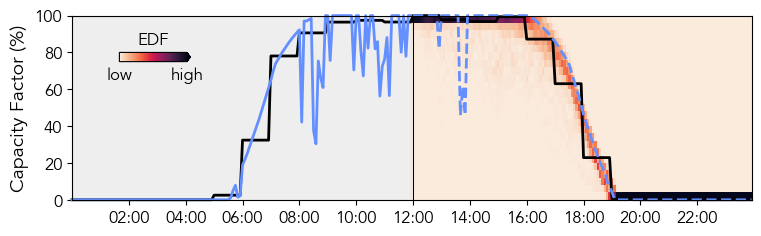

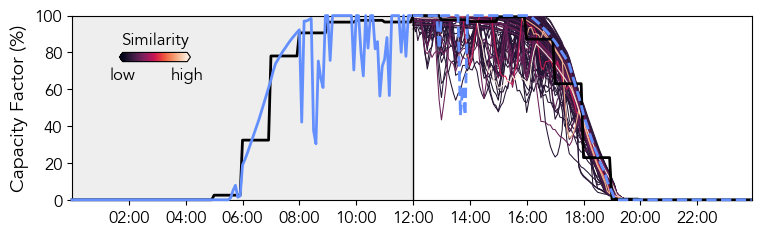

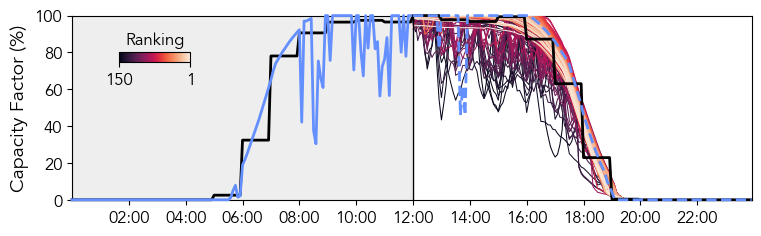

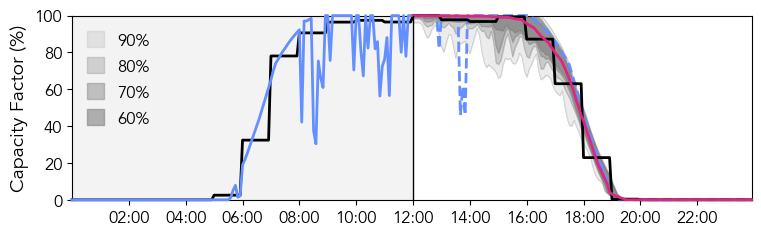

In [167]:
def _plot_updates(_fig, _ax, palette_, M_, f_, e_, f_hat_, w_, idx_, dx_, dt_, t, 
                  colorbar = True, legend = True):

    tau_ = dt_[:t]
    s_   = dt_[t:]

    z_   = (w_ - w_[idx_].min()) / (w_[idx_].max() - w_[idx_].min())
    idx_ = idx_[np.argsort(w_[idx_])]
    
    _cmap = sns.color_palette("rocket", as_cmap=True)
    _norm = plt.Normalize(0., 1)

    _ax.plot([], [], 
             label=r"$\hat{\mu}_i(s)$", 
             c="orange")

    for i, j in zip(idx_, range(idx_.shape[0])):
        _ax.plot(dt_[t:], 100 * M_[j, :],
                 c=_cmap(_norm(z_[i])), 
                 lw=0.75, 
                 zorder=8)

    _ax.fill_between(tau_, 100 * np.ones(tau_.shape), 100 * np.zeros(tau_.shape),
                     color="lightgray",
                     alpha=0.375,
                     zorder=1)

    _ax.plot(tau_, 100.0 * f_,
             c=palette_.loc[0, "ibm"],
             zorder=10,
             label="CF (actual)",
             clip_on=False,
             lw=2)

    _ax.plot(s_, 100.0 * f_hat_,
             c=palette_.loc[0, "ibm"],
             zorder=10,
             lw=2,
             clip_on=False,
             ls="--")

    _ax.plot(dt_, 100.0 * e_, 
             lw=2, 
             zorder=9, 
             label="CF (forecast)", 
             clip_on=False, 
             c="k")
    
    _ax.axvline(dt_[t], 
                color="k", 
                lw=1.0, 
                label="Event (update)", 
                zorder=8)
    
    _ax.set_xticks(dt_[24::24], dx_[24::24], rotation=0)
    # ax_[2].set_yticks(size = 12)
    _ax.set_ylim(0.0, 100.0)
    _ax.set_xlim(dt_[0], dt_[-1])
    _ax.set_ylabel("Capacity Factor (%)", size=14)
    
    _ax.tick_params(axis="both", 
                    labelsize=12)

    if legend:
        _ax.legend(frameon=False, 
                   loc      = "upper right",
                   fontsize=12, 
                   ncol=1)
    
    if colorbar:
        cbar = _fig.colorbar(cm.ScalarMappable(_norm, _cmap),
                             cax=_ax.inset_axes([100, 75, 150, 5], transform=_ax.transData),
                             orientation="horizontal",
                             extend="both")
    
        cbar.set_ticks([0, 1], 
                       labels=["low", "high"], 
                       size=12)
        
        cbar.ax.tick_params(length=0)
        
        cbar.ax.set_title("Similarity", 
                          rotation=0, 
                          size=12)
    
def _plot_density_heatmap(_ax, M_, f_, e_, f_hat_, dx_, dt_, t, legend = True, colorbar = True):

    tau_ = dt_[:t]
    s_ = dt_[t:]

    Z_ = []
    for i in range(M_.shape[1]):
        a_, b_ = np.histogram(100.0 * M_[:, i], 
                              bins=25, 
                              range=(0, 100), 
                              density=True)
        Z_.append(a_)

    Z_ = np.stack(Z_).T
    X_, Y_ = np.meshgrid(dt_[t:], (b_[1:] + b_[:-1]) / 2.0)

    _cmap = sns.color_palette("rocket_r", as_cmap=True)
    _ax.pcolormesh(X_, Y_, Z_, cmap =_cmap)

    _ax.plot(dt_, 100 * e_, 
             c="k", 
             lw=2.0, 
             label="CF (forecast)", 
             clip_on=False)

    _ax.plot(tau_, 100 * f_,
             c=palette_.loc[0, "ibm"],
             clip_on=False,
             lw=2.0,
             label="CF (actual)")

    _ax.plot(s_, 100 * f_hat_, 
             c=palette_.loc[0, "ibm"], 
             clip_on=False, 
             lw=2.0, 
             ls="--")

    _ax.fill_between(tau_, 100 * np.ones(tau_.shape), 100 * np.zeros(tau_.shape),
                     color="lightgray",
                     alpha=0.375)

    _ax.axvline(dt_[t], 
                color="k", 
                linewidth=0.75, 
                label="Event (update)")

    _ax.set_xticks(dt_[24::24], dx_[24::24], rotation=0)
    _ax.set_ylabel("Capacity Factor (%)", size=14)

    _ax.tick_params(axis="both", labelsize=12)

    _ax.set_ylim(0.0, 100)
    _ax.set_xlim(dt_[0], dt_[-1])

    if legend:
        _ax.legend(frameon  = False, 
                   loc      = "upper right",
                   fontsize = 12, 
                   ncol     = 1)
    if colorbar:
        cbar = fig.colorbar(cm.ScalarMappable(cmap=_cmap),
                            cax=_ax.inset_axes([100, 75, 150, 5], transform=_ax.transData),
                            orientation="horizontal",
                            extend="max")
    
        cbar.set_ticks([0, 1], 
                       labels=["low", "high"], 
                       fontsize = 12)
        cbar.ax.tick_params(length=0)
    
        cbar.ax.set_title("EDF", rotation=0)

def _plot_depth(_fig, _ax, palette_, M_, f_, e_, f_hat_, w_, dx_, dt_, t, legend = True):

    tau_ = dt_[:t]
    s_   = dt_[t:]

    idx_ = np.argsort(w_)
    _cmap = sns.color_palette("rocket", as_cmap=True)
    _norm = plt.Normalize(0., 1)

    _ax.plot([], [], 
             label=r"$\hat{\mu}_i(s)$", 
             c="orange")

    for i in range(idx_.shape[0]):
        _ax.plot(dt_[t:], 100 * M_[idx_[i], :],
                 c=_cmap(_norm(i/idx_.shape[0])), 
                 lw=0.75, 
                 zorder=8)
        
    _ax.fill_between(tau_, 100 * np.ones(tau_.shape), 100 * np.zeros(tau_.shape),
                     color="lightgray",
                     alpha=0.375,
                     zorder=1)

    _ax.plot(tau_, 100.0 * f_,
             c=palette_.loc[0, "ibm"],
             zorder=10,
             label="CF (ac)",
             clip_on=False,
             lw=2)

    _ax.plot(s_, 100.0 * f_hat_,
             c=palette_.loc[0, "ibm"],
             zorder=10,
             lw=2,
             clip_on=False,
             ls="--")

    _ax.plot(dt_, 100.0 * e_, 
             lw=2, 
             zorder=9, 
             label="CF (fc)", 
             clip_on=False, 
             c="k")

    _ax.axvline(dt_[t], 
                color="k", 
                lw=1.0, 
                label="Event (update)", 
                zorder=8)
    
    _ax.set_xticks(dt_[24::24], dx_[24::24], rotation=0)
    # ax_[2].set_yticks(size = 12)
    _ax.set_ylim(0.0, 100.0)
    _ax.set_xlim(dt_[0], dt_[-1])
    _ax.set_ylabel("Capacity Factor (%)", size=14)
    
    _ax.tick_params(axis="both", 
                    labelsize=12)
    
    if legend:
        _ax.legend(frameon=False, 
                   fontsize=12, 
                   ncol=1)

    cbar = _fig.colorbar(cm.ScalarMappable(_norm, _cmap),
                         cax=_ax.inset_axes([100, 75, 150, 5], transform=_ax.transData),
                         orientation="horizontal")

    cbar.set_ticks([0, 1], 
                   labels=[M_.shape[0], 1], 
                   size=12)
        
    cbar.ax.set_title("Ranking", 
                      rotation=0, 
                      size=12)

def _plot_envelop(_ax, _upper, _lower, f_, e_, f_hat_, m_, dt_, dx_, t, 
                  legend_1 = True, legend_2 = True):

    tau_ = dt_[:t]
    s_   = dt_[t:]

    s_p_ = np.concatenate([tau_[-1] * np.ones((1,)), s_], axis=0)

    _ax.plot(dt_, 100 * e_, 
             c="k", 
             lw=2.0, 
             label="CF (forecast)" if legend_1 else None, 
             zorder = 8,
             clip_on=False)

    _ax.plot(tau_, 100 * f_, 
            c       = palette_.loc[0, "ibm"], 
            label   = "CF (actual)" if legend_1 else None, 
            lw      = 2.0, 
            zorder = 8,
            clip_on = False)
    
    _ax.plot(s_, 100.0 * f_hat_, 
             c       = palette_.loc[0, "ibm"], 
             ls      = "--", 
             lw      = 2.0, 
             zorder = 7,
             clip_on = False)

    _ax.plot(s_, 100 * m_, 
            c       = palette_.loc[2, "ibm"], 
            label   = r"$\bar{\mu} (s)$" if legend_1 else None,
            lw      = 2.0, 
            zorder  = 9,
            clip_on = False)
    
    _ax.axvline(dt_[t], 
                color     = "k", 
                linewidth = 1.0, 
                label     = "Event (update)" if legend_1 else None, 
                zorder    = 10)
    
    for key, i in zip(_upper.keys(), range(len(_upper.keys()))):

        upper_ = np.concatenate([f_, _upper[key]], axis=0)[f_.shape[0] - 1:]
        lower_ = np.concatenate([f_, _lower[key]], axis=0)[f_.shape[0] - 1:]

        _ax.plot(s_p_, 100. * upper_, 
                 lw = 0.125, 
                 c  = "gray")
        
        _ax.plot(s_p_, 100. * lower_, 
                 lw = 0.125, 
                 c  = "gray")

        alpha = float(key)
        ci    = int((1. - alpha)*100)
        
        _ax.fill_between(s_p_, 100. * upper_, 100. * lower_,
                        color  = "gray",
                        alpha  = 0.15 + i * 0.15,
                        label  = f"{ci}%" if legend_2 else None,
                        zorder = 1)
            
    _ax.fill_between(tau_, 100 * np.ones(tau_.shape), 100 * np.zeros(tau_.shape),
                     color = "lightgray",
                     alpha = 0.25)

    _ax.set_xticks(dt_[24::24], dx_[24::24], rotation=0)
    
    if legend_1 | legend_2: 
        _ax.legend(frameon  = False, 
                   loc      = "upper left",
                   fontsize = 12,
                   ncol     = 1)
        
    _ax.tick_params(axis      = "both", 
                    labelsize = 12)
    
    _ax.set_ylim(0.0, 100)
    _ax.set_xlim(dt_[0], dt_[-1])
    _ax.set_ylabel("Capacity Factor (%)", size = 14)
    
    
fig, _ax = plt.subplots(1, 1, 
                        figsize=(7.5, 2.25), 
                        layout="constrained")

_plot_density_heatmap(_ax, M_, f_, e_, f_hat_, dx_, dt_, t, 
                      legend = False, 
                      colorbar = True)

plt.savefig(path_to_images + f"/EDF_heatmap_{file_name}.png", 
            bbox_inches="tight", 
            dpi=600)

plt.show()

_fig, _ax = plt.subplots(1, 1, 
                        figsize=(7.5, 2.25), 
                        layout="constrained")

_plot_updates(_fig, _ax, palette_, M_, f_, e_, f_hat_, _meta['w'], _meta['idx_4'], dx_, dt_, t, 
              legend = False, 
              colorbar = True)

plt.savefig(path_to_images + f"/dynamic_update_neighbors_{file_name}.png", 
            bbox_inches="tight", 
            dpi=600)

plt.show()

depth = 'LD'
d_ = _fDepth(M_, depth, path_to_fDepth).to_numpy()[:, 0]

fig, _ax = plt.subplots(1, 1, 
                        figsize=(7.5, 2.25), 
                        layout="constrained")

_plot_depth(_fig, _ax, palette_, M_, f_, e_, f_hat_, d_, dx_, dt_, t, 
            legend = False)

plt.savefig(path_to_images + f"/{depth}_ranking_{file_name}.png", 
            bbox_inches="tight", 
            dpi=600)

plt.show()

# Calculate confidence intervals from Directional Quantiles
alpha_ = [0.1, 0.2, 0.3, 0.4]
#m_, _upper, _lower = _confidence_intervals_from_fDepth(M_, alpha_, 'LD', path_to_fDepth)
m_, _upper, _lower = _confidence_intervals_from_eCDF(M_, alpha_)

_fig, _ax = plt.subplots(1, 1, 
                        figsize=(7.5, 2.25), 
                        layout="constrained")

_plot_envelop(_ax, _upper, _lower, f_, e_, f_hat_, m_, dt_, dx_, t, 
              legend_1 = False, 
              legend_2 = True)

plt.savefig(path_to_images + f"/EDF_envelop_{file_name}.png", 
            bbox_inches="tight", 
            dpi=600)

solar-30-90-120
Cottonwood Bayou 2018-04-01 10:00:00
solar-30-90-144
Cottonwood Bayou 2018-04-01 12:00:00
solar-30-90-168
Cottonwood Bayou 2018-04-01 14:00:00


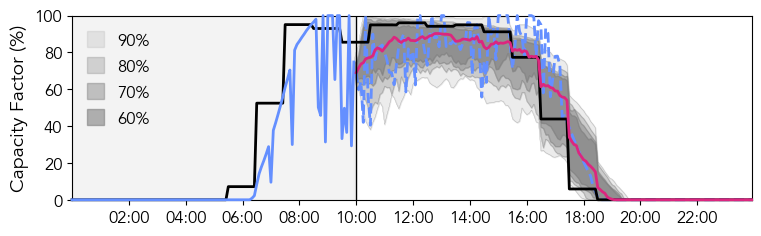

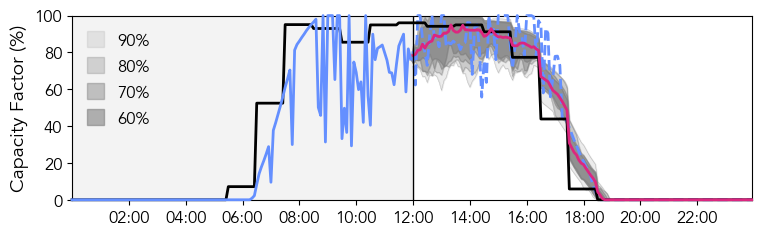

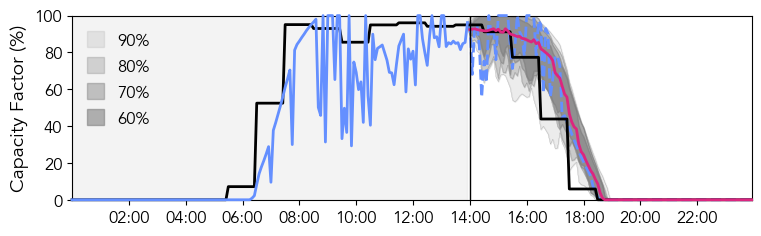

In [65]:
for i in [10, 12, 14]:

    a = 30
    d = 90
    t = i * 12
    file_name = f"{resource}-{a}-{d}-{t}"
    print(file_name)
    
    f_     = F_ts_[d, :t, a]
    e_     = E_ts_[d, :, a]
    x_     = x_ts_[a, :]
    time   = t_ts_[d]
    f_hat_ = F_ts_[d, t:, a]
    
    _meta, M_ = _fknn_forecast_dynamic_update(F_tr_, E_tr_, x_tr_, t_tr_, dt_, f_, e_, x_, time,
                                              forget_rate_f  = params_['forget_rate_f'][t],
                                              forget_rate_e  = params_['forget_rate_e'][t],
                                              length_scale_f = params_['length_scale_f'][t],
                                              length_scale_e = params_['length_scale_e'][t],
                                              lookup_rate    = params_['lookup_rate'][t],
                                              trust_rate     = params_['trust_rate'][t],
                                              nu             = params_['nu'][t],
                                              gamma          = params_['xi'][t],
                                              xi             = params_['gamma'][t],
                                              kappa_min      = params_['kappa_min'][t],
                                              kappa_max      = params_['kappa_max'][t], 
                                              idx_hours_     = idx_hours_)
    
    print(assets_ts_[a], T_ts_[d, t])

    # fig, _ax = plt.subplots(1, 1, 
    #                         figsize=(7.5, 2.25), 
    #                         layout="constrained")
    
    # _plot_density_heatmap(_ax, M_, f_, e_, f_hat_, dx_, dt_, t, 
    #                       legend = False, 
    #                       colorbar = True)
    
    # plt.savefig(path_to_images + f"/EDF_heatmap_{file_name}.pdf", 
    #             bbox_inches="tight", 
    #             dpi=600)
    
    # plt.show()

    # _fig, _ax = plt.subplots(1, 1, 
    #                         figsize=(7.5, 2.25), 
    #                         layout="constrained")
    
    # depth = 'MBD'
    # d_ = _fDepth(M_, depth, path_to_fDepth).to_numpy()[:, 0]
    
    # _plot_depth(_fig, _ax, palette_, M_, f_, e_, f_hat_, d_, dx_, dt_, t, 
    #             legend = False)
    
    # plt.savefig(path_to_images + f"/{depth}_ranking_{file_name}.pdf", 
    #             bbox_inches="tight", 
    #             dpi=600)
    
    # plt.show()

    _fig, _ax = plt.subplots(1, 1, 
                            figsize=(7.5, 2.25), 
                            layout="constrained")
    
    # Calculate confidence intervals from Directional Quantiles
    alpha_ = [0.1, 0.2, 0.3, 0.4]
    #m_, _upper, _lower = _confidence_intervals_from_fDepth(M_, alpha_, 'LD', path_to_fDepth)
    m_, _upper, _lower = _confidence_intervals_from_eCDF(M_, alpha_)
    
    _plot_envelop(_ax, _upper, _lower, f_, e_, f_hat_, m_, dt_, dx_, t, 
                  legend_1 = False, 
                  legend_2 = True)
    
    plt.savefig(path_to_images + f"/BD_envelop_{file_name}.pdf", 
                bbox_inches="tight", 
                dpi=600)

24.908481999438866
[-95.38  29.29]


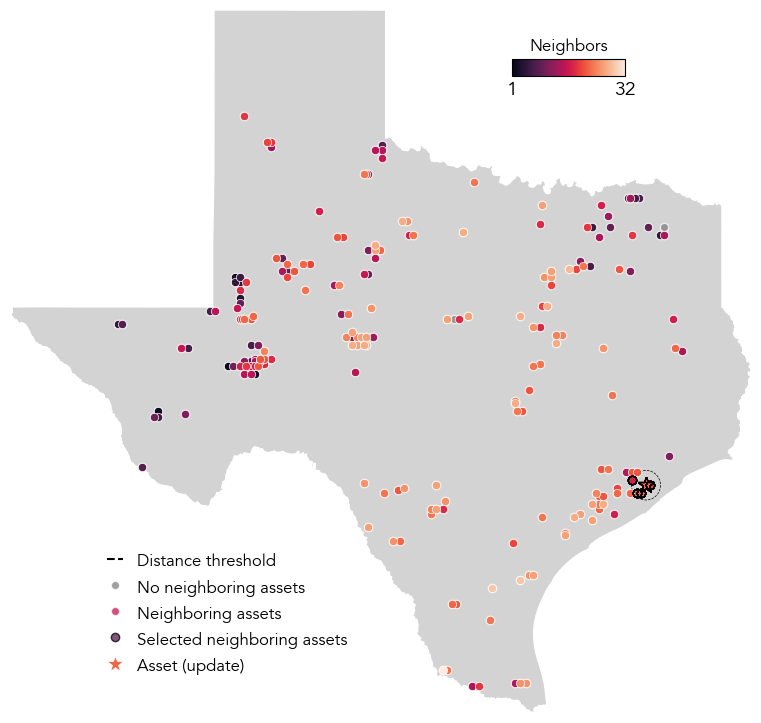

In [20]:
def _plot_frequency_map(_fig, _ax, TX_, x_tr_, x_ts_, x_, idx_1_, idx_2_, sigma):

    print(sigma)
    x_tr_p_, z_tr_p_ = np.unique(x_tr_[idx_1_, :], 
                                 return_counts = True, 
                                 axis = 0)

    _cmap = sns.color_palette("rocket", as_cmap=True)
    _norm = plt.Normalize(1, z_tr_p_.max())

    TX_.plot(ax=_ax, 
             facecolor="lightgray", 
             edgecolor="white", 
             zorder=0)

    # _ax.scatter(x_[0], x_[1],
    #             c="lime",
    #             lw=1,
    #             ec="k",
    #             s=110,
    #             zorder=1,
    #             marker="o",
    #             clip_on=False,
    #             label="Asset (update)")
    
    _ax.plot(x_[0], x_[1],
             c="k",
             marker="None",
             ls="--",
             clip_on=False,
             label="Distance threshold")

    _ax.plot(x_ts_[:, 0], x_ts_[:, 1],
             c="gray",
             alpha=0.75,
             ms=6,
             marker="o",
             mec="w",
             ls="none",
             mew=1.0,
             zorder=2, clip_on=False,
             label="No neighboring assets")
    
    _ax.plot(x_[0], x_[1],
             c=_cmap(_norm(z_tr_p_.max() / 2.0)),
             alpha=0.75,
             ms=6,
             ls="none",
             marker="o",
             mec="w",
             mew=1.0,
             zorder=0, 
             clip_on=False,
             label="Neighboring assets")

    _ax.plot(x_[0], x_[1],
             c=_cmap(_norm(z_tr_p_.max() / 4.0)),
             alpha=0.75,
             ms=6,
             ls="none",
             marker="o",
             mec="k",
             mew=1.0,
             zorder=0, clip_on=False,
             label="Selected neighboring assets")

    for i in np.arange(x_tr_p_.shape[0], dtype=int)[np.argsort(z_tr_p_)]:
        if (x_tr_p_[i, 0] != x_[0]) | (x_tr_p_[i, 1] != x_[1]):
            _ax.plot(x_tr_p_[i, 0], x_tr_p_[i, 1],
                     c=_cmap(_norm(z_tr_p_[i])),
                     ms=6,
                     ls="none",
                     marker="o",
                     mec="w",
                     mew=.5,
                     zorder=4, 
                     clip_on=False)
        else:
            _ax.plot(x_tr_p_[i, 0], x_tr_p_[i, 1],
                     c=_cmap(_norm(z_tr_p_[i])),
                     ms=12,
                     ls="none",
                     marker="*",
                     mec="w",
                     mew=.5,
                     zorder=4, 
                     clip_on=False, 
                     label = 'Asset (update)')
    
    for i in range(x_tr_[idx_2_, :].shape[0]):
        if (x_tr_[idx_2_[i], 0] != x_[0]) | (x_tr_[idx_2_[i], 1] != x_[1]):
            _ax.plot(x_tr_[idx_2_[i], 0], x_tr_[idx_2_[i], 1],
                     ms=6,
                     ls="none",
                     marker="o",
                     c = 'none', 
                     mec="k",
                     mew=.75,
                     zorder=5, 
                     clip_on=False)
        else:
            _ax.plot(x_tr_[idx_2_[i], 0], x_tr_[idx_2_[i], 1],
                     ms=12,
                     ls="none",
                     marker="*",
                     c = 'none', 
                     mec="k",
                     mew=.75,
                     zorder=5, 
                     clip_on=False)
    
    minx, miny, maxx, maxy = TX_.total_bounds
    X_, Y_ = np.meshgrid(np.linspace(minx, maxx, 1000), 
                         np.linspace(miny, maxy, 1000))
    
    Z_ = _haversine_dist(x_, np.concatenate([X_.flatten()[:, np.newaxis], 
                                             Y_.flatten()[:, np.newaxis]], axis = 1)).reshape(X_.shape)


    contours = _ax.contour(X_, Y_, Z_, 
                           levels = [sigma], 
                           colors = 'k', 
                           linewidths = 0.5, 
                           linestyles = 'dashed')

    cbar = _fig.colorbar(cm.ScalarMappable(cmap = _cmap),
                         cax=_ax.inset_axes([-97.75, 35.5, 2.0, 0.25], transform = _ax.transData),
                         orientation="horizontal")

    cbar.set_ticks([0, 1], 
                   labels=[1, int(z_tr_p_.max())], 
                   fontsize=14)
    
    cbar.ax.tick_params(length=0)
    
    cbar.ax.set_title("Neighbors", 
                      rotation = 0, 
                      fontsize = 12)

    _ax.legend(frameon=False,
               bbox_to_anchor=(0.475, 0.25),
               ncol=1,
               fontsize=12)
    
    _ax.set_axis_off()

_fig, _ax = plt.subplots(1, 1, 
                        figsize=(7.5, 7.5), 
                        layout="constrained")

_plot_frequency_map(_fig, _ax, TX_, x_tr_, x_ts_, x_ts_[a, :], idx_2_, idx_4_, sigma)

# # Add compass (North arrow)
# x, y, arrow_length = 0.1725, 0.95, 0.0625  # relative axes coords
# _ax.annotate("N",
#              xy=(x, y),
#              xytext=(x, y - arrow_length),
#              arrowprops=dict(facecolor="k", 
#                              arrowstyle="wedge,tail_width=1,shrink_factor=.5"),
#              ha="center",
#              va="center",
#              fontsize=14,
#              xycoords=_ax.transAxes)

# scalebar = ScaleBar(dx=100,  # scaling factor
#                     units="km",
#                     dimension="si-length",  # could also be 'imperial-length'
#                     location='upper left',
#                     length_fraction=0.09,  # fraction of the axis for bar length
#                     color="black",
#                     box_color="None",
#                     box_alpha=1.0,
#                     border_pad=9,
#                     font_properties={"size": 14})

# _ax.add_artist(scalebar)


plt.savefig(path_to_images + f"/spatial_neiboring_assets_{file_name}.pdf", 
            bbox_inches="tight", 
            dpi=600)

plt.show()

(76593, 288)
2018-04-04 14:00:00
3 3
7076 Apr


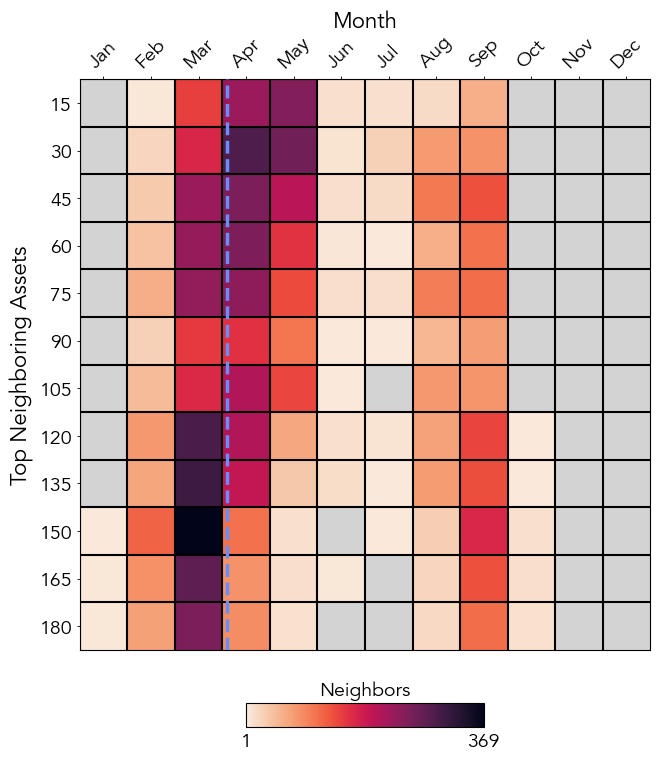

In [21]:
def _selected_scenarios_heatmap(_ax, T_tr_, d_h_, x_ts_, x_, idx_1_, t_ts, 
                                xlabel = True,
                                colorbar = True):

    N     = 12
    delta = 15

    d_      = _haversine_dist(x_, x_ts_)
    d_sort_ = np.sort(d_)[:-7]

    tops_      = [int((i + 1) * delta) for i in range(N)]
    intervals_ = [d_sort_[i - 1] for i in tops_]
    print(t_ts)
    _date     = datetime.datetime.strptime(t_ts, "%Y-%m-%d %H:%M:%S")
    m_a       = _date.timetuple().tm_mon - 1
    day       = _date.timetuple().tm_mday - 1
    _, n_days = calendar.monthrange(_date.year, m_a + 1)

    m_tr_ = np.stack([datetime.datetime.strptime(T_tr_[i], "%Y-%m-%d %H:%M:%S").timetuple().tm_mon - 1
                      for i in range(T_tr_.shape[0])])
    print(m_a, day)
    K        = 0
    heatmap_ = np.zeros((N + 1, m_tr_.max() + 1))
    for d_h, m in zip(d_h_[idx_1_], m_tr_[idx_1_]):
        heatmap_[np.searchsorted(intervals_, d_h), m] += 1
        K += 1
        
    h_max = int(heatmap_.max())
    heatmap_[heatmap_ == 0.] = np.nan

    _cmap = sns.color_palette("rocket_r", as_cmap=True)
    _cmap.set_bad(color= 'lightgray')  # RGBA: transparent
    
    month_ = ["Jan",
              "Feb",
              "Mar",
              "Apr",
              "May",
              "Jun",
              "Jul",
              "Aug",
              "Sep",
              "Oct",
              "Nov",
              "Dec"]

    print(K, month_[m_a])

    _ax.matshow(heatmap_[:-1, :], 
                cmap=_cmap, 
                vmin=0.0, 
                extent=[0, 12, N, 0])

    _ax.set_xticks(range(len(month_)), [] * len(month_))
    _ax.set_yticks(range(len(tops_)), [] * len(tops_))

    _ax.set_ylabel("Top Neighboring Assets", size=16)
    
    if xlabel:
        _ax.set_xlabel("Month", size=16)
    _ax.xaxis.set_label_position("top")

    _ax.set_xticks(np.arange(len(month_), dtype=int) + 0.5, month_,
                   rotation=45,
                   minor=True,
                   size=14)

    _ax.set_yticks(np.arange(len(tops_), dtype=int) + 0.5, tops_,
                   minor=True,
                   size=14)

    _ax.tick_params(which="major", 
                    bottom=False, 
                    left=False, 
                    top=False)
    
    _ax.tick_params(which="minor", 
                    bottom=False)
    
    _ax.grid(which="major", 
             color="k", 
             linestyle="-", 
             linewidth=1.5)

    _ax.axvline(m_a + day/n_days, 
                color=palette_.loc[0, "ibm"], 
                ls = '--',
                lw=2.5, 
                zorder=6)
    
    if colorbar:
        cbar = _fig.colorbar(cm.ScalarMappable(cmap = _cmap),
                             cax = _ax.inset_axes([3.5, 13.125, 5., 0.5], transform = _ax.transData),
                             orientation="horizontal")
    
        cbar.set_ticks([0, 1], 
                       labels=[1, h_max], 
                       fontsize=14)
        
        cbar.ax.tick_params(length=0)
        
        cbar.ax.set_title("Neighbors", 
                          rotation = 0, 
                          fontsize = 14)


fig, _ax = plt.subplots(1, 1, 
                        figsize=(7.5, 7.5), 
                        layout="constrained")

print(T_tr_.shape)
_selected_scenarios_heatmap(_ax, T_tr_[:, t], d_h_, x_ts_, x_ts_[a, :], idx_1_, T_ts_[d, t], 
                            xlabel = True,
                            colorbar = True)

plt.savefig(path_to_images + f"/seasonly_neiboring_assets_{file_name}.pdf", 
            bbox_inches="tight", 
            dpi=600)

plt.show()


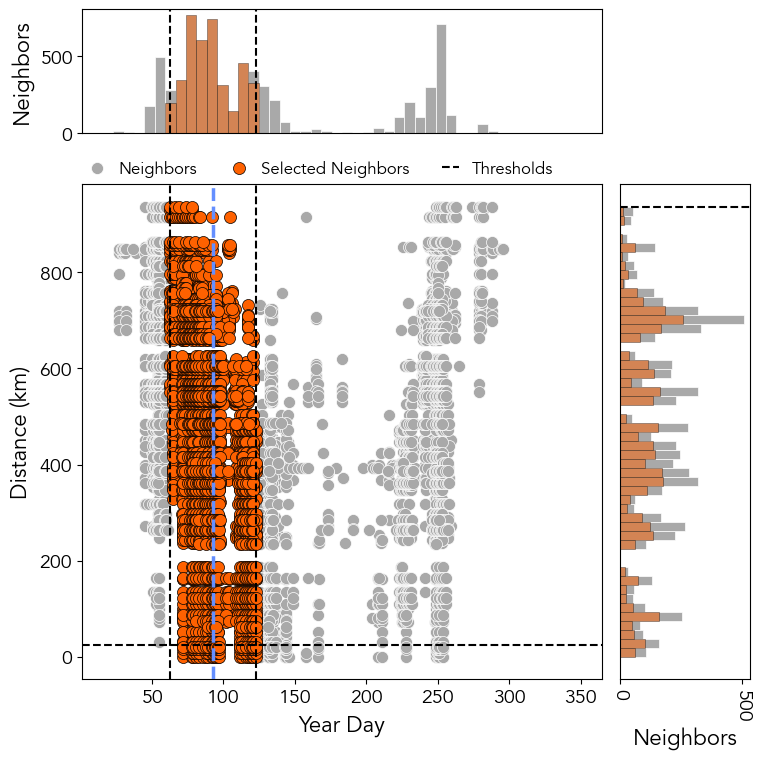

In [22]:
def _plot_scenario_filtering(_ax, d_h_, t_tr_, idx_1_, idx_2_, t_ts, Gamma, gamma, sigma):

    def __check_limit(x):
        if x > 365:
            x = x - 365
        if x < 1:
            x = x + 365
        return x

    _ax.scatter(t_tr_[idx_1_], d_h_[idx_1_],
                s=75,
                c="darkgray",
                lw=0.5,
                edgecolor="w",
                clip_on=False,
                zorder=4,
                label="Neighbors")

    _ax.scatter(t_tr_[idx_2_], d_h_[idx_2_],
                s=75,
                c=palette_.loc[3, "ibm"],
                lw=0.5,
                edgecolor="k",
                clip_on=False,
                zorder=5,
                label="Selected Neighbors")


    _ax.axvline(t_ts, 
                color=palette_.loc[0, "ibm"], 
                ls = '--',
                lw=2.5, 
                zorder=6)

    if Gamma != 0:  
        _ax.axvline(__check_limit(t_ts + gamma), 
                    c="k", 
                    ls='--', 
                    lw=1.5, 
                    zorder=10)
                    
        _ax.axvline(__check_limit(t_ts - gamma), 
                    c="k", 
                    ls='--', 
                    lw=1.5, 
                    zorder=10, 
                    label="Thresholds")

    
    if sigma != 0:
        _ax.axhline(sigma, 
                    c="k", 
                    ls='--', 
                    lw=1.5, 
                    zorder=10)

    #_ax.set_ylabel(r"$|| \mathbf{x}_\star - \mathbf{x}_n ||_\mathrm{H}$", size=14)
    #_ax.set_xlabel(r"$|| d_\star - d_n ||_\mathrm{p}$", size=16)
    _ax.set_xlabel(r"Year Day", size=16)
    _ax.set_ylabel(r"Distance (km)", size=16)

    _ax.tick_params(axis="both", 
                    labelsize=14)

    _ax.set_xlim(1, 365)


def _plot_dates_histogram(_ax, t_tr_, idx_1_, idx_2_, t_ts, Gamma, gamma):

    def __check_limit(x):
        if x > 365:
            x = x - 365
        if x < 1:
            x = x + 365
        return x

    _ax.hist(t_tr_[idx_1_], 
             bins=50, 
             range=(1, 365), 
             color="darkgray", 
             edgecolor="w", 
             lw=0.5)

    _ax.hist(t_tr_[idx_2_],
             bins=50,
             range=(1, 365),
             alpha=0.5,
             color=palette_.loc[3, "ibm"],
             edgecolor="k",
             lw=0.5)
    
    if Gamma != 0:  
        _ax.axvline(__check_limit(t_ts - gamma), 
                    c="k", 
                    ls="--", 
                    lw=1.5, 
                    zorder=2, 
                    label="d: day")
        
        _ax.axvline(__check_limit(t_ts + gamma), 
                    c="k", 
                    ls="--", 
                    lw=1.5, 
                    zorder=2, 
                    label="d: day")
        
    #_ax.set_xlabel(r"Year Day", size=16)
    _ax.set_ylabel(r"Neighbors", size=16)
    _ax.set_xlim(1, 365)
    _ax.tick_params(axis="both", labelsize=14)
    #_ax.legend(frameon=False, ncol=1, fontsize = 12)
    _ax.set_xticks([], [])

def _plot_distance_histogram(_ax, d_h_, idx_1_, idx_2_, d_max = 1200):

    d_max = d_h_.max()
    
    _ax.hist(d_h_[idx_1_], 
             bins=50, 
             range=(0, d_max), 
             color="darkgray", 
             edgecolor="w", 
             lw=0.5, 
             orientation="horizontal")
    
    _ax.hist(d_h_[idx_2_],
             bins=50,
             range=(0, d_max),    
             alpha=0.5,
             color=palette_.loc[3, "ibm"],
             edgecolor="k",
             lw=0.5, 
             orientation="horizontal")
    
    _ax.axhline(d_h_[idx_2_].max(), 
                c="k", 
                ls="--", 
                lw=1.5, 
                zorder=2, 
                label="r: max distance")
    
    #_ax.set_xlabel(r"Distance (km)", size=16)
    _ax.set_xlabel(r"Neighbors", size=16)
    #_ax.set_xlim(0, d_max)
    _ax.tick_params(axis="both", labelsize=14, rotation = 270)
    _ax.set_yticks([], [])

    #_ax.legend(frameon=False, ncol=1, fontsize = 12)

fig, _ax = plt.subplot_mosaic([["A", "."], 
                               ["B", "C"]],
                              figsize     = (7.5, 7.5),
                              layout      = "constrained",
                              gridspec_kw = dict(width_ratios  = (1, .25), 
                                                 height_ratios = (.25, 1)))


_plot_dates_histogram(_ax["A"], t_tr_, idx_1_, idx_2_, t_ts_[d], Gamma, gamma)
_plot_scenario_filtering(_ax["B"], d_h_, t_tr_, idx_1_, idx_2_, t_ts_[d], Gamma, gamma, sigma)
_plot_distance_histogram(_ax["C"], d_h_, idx_1_, idx_2_, d_max = 1200)

_ax["B"].legend(frameon=False, 
                ncol=3, 
                loc = (0., 1.), 
                fontsize = 12)

plt.savefig(path_to_images + f"/kNN_frequency_{file_name}.pdf", 
            bbox_inches="tight", 
            dpi=600)

plt.show()

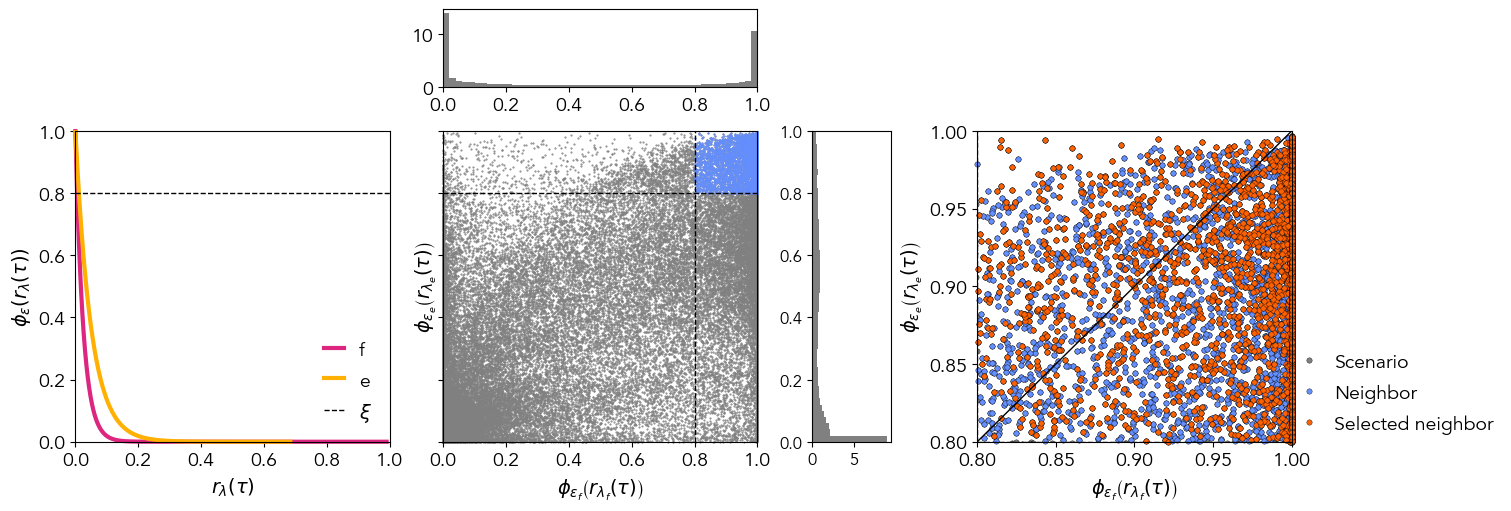

In [23]:
def _plot_density_threshold(_ax, d_f_, d_e_, w_f_, w_e_, w_, idx_0_, idx_1_, idx_2_, xi):

    _ax.plot(d_f_[np.argsort(d_f_)], w_f_[np.argsort(d_f_)],
             c=palette_.loc[2, "ibm"],
             lw=3,
             label="f", 
             clip_on = False)

    _ax.plot(d_e_[np.argsort(d_e_)], w_e_[np.argsort(d_e_)],
             c=palette_.loc[4, "ibm"],
             lw=3,
             label="e", 
             clip_on = False)

    _ax.axhline(xi, 
                ls="--", 
                color="k", 
                lw=1.0, 
                label=r"$\xi$", 
                zorder=10)
    
    _ax.set_ylabel(r"$\phi_{\varepsilon} \left( r_{\lambda} \left( \tau \right) \right)$", size=14)
    _ax.set_xlabel(r"$r_{\lambda} \left( \tau \right)$", size=14)
    
    _ax.tick_params(axis="both", 
                    labelsize=14)
    
    _ax.legend(frameon=False, 
               fontsize=14)

    _ax.set_ylim(0, 1)
    _ax.set_xlim(0, 1)

    
def _plot_fneighborhood(_ax, _ax_top, _ax_left, d_f_, d_e_, w_f_, w_e_, w_, idx_0_, xi):

    #c_ = [palette_.loc[2, "ibm"], palette_.loc[4, "ibm"]]

    _ax.tick_params(axis="y", 
                    labelleft=False)

    _ax.scatter(w_f_, w_e_, 
                color="gray", 
                s=0.25, 
                zorder=1, 
                clip_on = False)

    _ax.scatter(w_f_[idx_0_], w_e_[idx_0_], 
                c=palette_.loc[0, "ibm"],
                s=0.25, 
                zorder=2, 
                clip_on = False)

    _ax.axhline(xi, 
                ls="--", 
                color="k", 
                lw=1.0, 
                label=r"$\xi$", 
                zorder=10)

    _ax.axvline(xi, 
                ls="--", 
                color="k", 
                lw=1.0, 
                label=r"$\xi$", 
                zorder=10)

    _ax.set_ylabel(r"$\phi_{\varepsilon_e} \left( r_{\lambda_e} \left( \tau \right) \right)$", size=14)
    _ax.set_xlabel(r"$\phi_{\varepsilon_f} \left( r_{\lambda_f} \left( \tau \right)  \right)$", size=14)
    _ax.tick_params(axis="both", labelsize=14)

    _ax.set_ylim(0, 1)
    _ax.set_xlim(0, 1)

    _ax_top.hist(w_f_, 
                  bins=50, 
                  color="gray", 
                  density=True)

    # _ax["c"].tick_params(axis="x", 
    #                      labelbottom=False)
    
    _ax_top.tick_params(axis="both", 
                         labelsize=14)
    
    _ax_top.set_xlim(0, 1)

    _ax_left.hist(w_e_, 
                  bins=50, 
                  color="gray", 
                  density=True, 
                  orientation="horizontal")
    
    _ax_left.set_ylim(0, 1)

    _ax_left.tick_params(axis="both", 
                         labelsize=12)

def _plot_selection(_ax, d_f_, d_e_, w_f_, w_e_, w_, idx_0_, idx_1_, idx_2_, xi):

    _ax.scatter(w_f_, w_e_, 
                c="gray", 
                s=15, 
                alpha=1.0,
                lw=0.25, 
                ec="k", 
                label="Scenario", 
                clip_on = True)

    _ax.scatter(w_f_[idx_0_], w_e_[idx_0_],
                c=palette_.loc[0, "ibm"],
                s=15,
                alpha=1.0,
                lw=0.25,
                ec="k",
                label="Neighbor",
                clip_on = False)

    _ax.scatter(w_f_[idx_1_], w_e_[idx_1_],
                c=palette_.loc[3, "ibm"],
                s=15,
                lw=0.25,
                ec="k",
                alpha=1.0,
                label="Selected neighbor", 
                clip_on = False)

    _ax.axline((1, 1), 
               slope=1, 
               lw=1, 
               c="k")
    
    _ax.set_ylabel(r"$\phi_{\varepsilon_e} \left( r_{\lambda_e} \left( \tau \right) \right)$", size=14)
    _ax.set_xlabel(r"$\phi_{\varepsilon_f} \left( r_{\lambda_f} \left( \tau \right) \right)$", size=14)
    
    _ax.tick_params(axis="both", 
                    labelsize=14)
    
    _ax.set_xlim(xi, 1)
    _ax.set_ylim(xi, 1)
    
    _ax.axhline(xi, 
                ls="--", 
                color="k", 
                lw=1.0, 
                zorder=10)
    
    _ax.axvline(xi, 
                ls="--", 
                color="k", 
                lw=1.0, 
                zorder=10)
    
    _ax.legend(frameon=False, 
               fontsize=14, 
               ncol=1, 
               loc=(1., 0.))

  
fig, _ax = plt.subplot_mosaic([[".", ".", "e", ".", ".", "."],
                               ["A", "A", "B", "f", "C", "C"],
                               ["A", "A", "B", "f", "C", "C"]],
                               figsize     = (15, 5.),
                               layout      = "constrained",
                               gridspec_kw = dict(width_ratios  = (2, 2, 4, 1, 2, 2), 
                                                  height_ratios = (1, 2, 2)))

# for label, ax in _ax.items():
#     if label.isupper():
#         ax.text(0.0, 1.0, label, 
#                 transform = (ax.transAxes + ScaledTranslation(-20/72, +7/72, _fig.dpi_scale_trans)),
#                 fontsize  = 22, 
#                 weight    = "bold",
#                 va        = 'bottom',
#                 family    = 'Arial')
    
_plot_density_threshold(_ax["A"], d_f_, d_e_, w_f_, w_e_, w_, idx_1_, idx_2_, idx_4_, xi)

_plot_fneighborhood(_ax["B"], _ax["e"], _ax["f"], d_f_, d_e_, w_f_, w_e_, w_, idx_1_, xi)

_plot_selection(_ax["C"], d_f_, d_e_, w_f_, w_e_, w_, idx_1_, idx_2_, idx_4_, xi)

plt.savefig(path_to_images + f"/fneighbor_{file_name}.pdf", 
            bbox_inches="tight", 
            dpi=600)

plt.show()

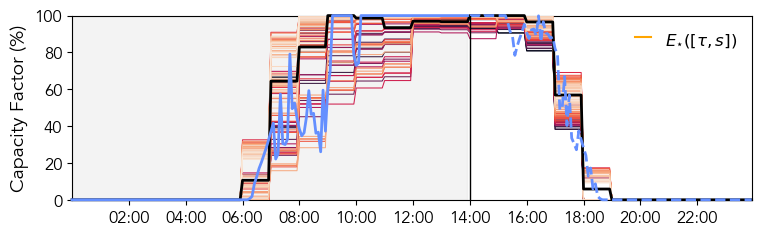

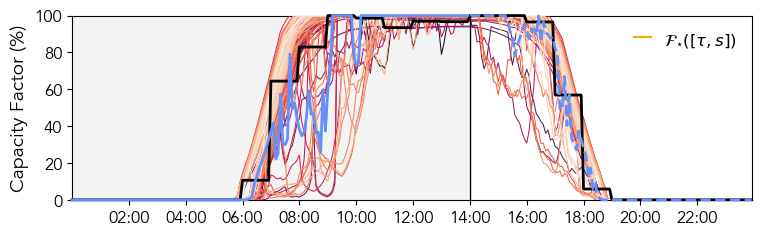

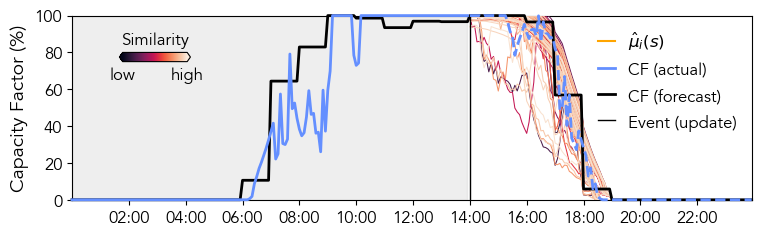

In [54]:
def _plot_forecasts(_ax, palette_, E_tr_, f_, e_, f_hat_, w_, idx_, dx_, dt_, t):

    tau_ = dt_[:t]
    s_   = dt_[t:]

    z_   = (w_ - w_[idx_].min()) / (w_[idx_].max() - w_[idx_].min())
    idx_ = idx_[np.argsort(w_[idx_])]

    _cmap = sns.color_palette("rocket", as_cmap=True)
    _norm = plt.Normalize(0, 1)

    _ax.plot(tau_, 100.0 * f_,
             c=palette_.loc[0, "ibm"],
             clip_on=False,
             zorder=10,
             #label="CF (ac)",
             lw=2)

    _ax.plot(s_, 100.0 * f_hat_,
             c=palette_.loc[0, "ibm"],
             clip_on=False,
             zorder=10,
             lw=2,
             ls="--")

    _ax.plot(dt_, 100.0 * e_, 
             clip_on=False, 
             lw=2, 
             zorder=9, 
             #label="CF (fc)", 
             c="k")

    _ax.plot([], [], 
             label=r"$E_{\star} \left([\tau, s]\right)$", 
             c="orange")

    for i, j in zip(idx_, range(idx_.shape[0])):
        _ax.plot(dt_, 100 * E_tr_[i, :], 
                 c=_cmap(_norm(z_[i])), 
                 lw=0.75, 
                 zorder=8)

    _ax.fill_between(tau_, 100 * np.ones(tau_.shape), 100 * np.zeros(tau_.shape),
                     color="lightgray",
                     alpha=0.25,
                     zorder=1)

    _ax.axvline(dt_[t], 
                color="k", 
                lw=1.0, 
                zorder=11)

    _ax.set_xticks(dt_[24::24], dx_[24::24], rotation=0)

    _ax.set_ylim(0.0, 100)
    _ax.set_xlim(dt_[0], dt_[-1])
    _ax.set_ylabel("Capacity Factor (%)", size=14)

    _ax.tick_params(axis="both", 
                    labelsize=12)

    _ax.legend(frameon=False, 
               fontsize=12, 
               ncol=1)
    
def _plot_neighbors(_ax, palette_, F_tr_, f_, e_, f_hat_, w_, idx_, dx_, dt_, t):

    tau_ = dt_[:t]
    s_   = dt_[t:]

    z_   = (w_ - w_[idx_].min()) / (w_[idx_].max() - w_[idx_].min())
    idx_ = idx_[np.argsort(w_[idx_])]

    _cmap = sns.color_palette("rocket", as_cmap=True)
    _norm = plt.Normalize(0., 1.)

    _ax.plot(tau_, 100.0 * f_, 
             c=palette_.loc[0, "ibm"], 
             zorder=10, 
             #label="CF (ac)", 
             lw=2, clip_on=False)

    _ax.plot(s_, 100.0 * f_hat_, 
             c=palette_.loc[0, "ibm"], 
             zorder=10, 
             lw=2, 
             ls="--", clip_on=False)

    _ax.plot(dt_, 100.0 * e_, 
             lw=2, 
             zorder=9, 
             #label="CF (fc)", 
             c="k", clip_on=False)

    _ax.plot([], [], 
             label=r"$\mathcal{F}_{\star} \left([\tau, s] \right)$", 
             c="orange")

    for i, j in zip(idx_, range(idx_.shape[0])):
        _ax.plot(dt_, 100 * F_tr_[i, :], 
                 c=_cmap(_norm(z_[i])), 
                 lw=0.75, 
                 zorder=8)

    _ax.fill_between(tau_, 100 * np.ones(tau_.shape), 100 * np.zeros(tau_.shape),
                     color="lightgray",
                     alpha=0.25,
                     zorder=1)

    _ax.axvline(dt_[t], 
                color="k", 
                lw=1.0, 
                zorder=11)

    _ax.set_xticks(dt_[24::24], dx_[24::24], rotation=0)
    _ax.set_ylim(0.0, 100.0)
    _ax.set_xlim(dt_[0], dt_[-1])
    _ax.set_ylabel("Capacity Factor (%)", size=14)

    _ax.tick_params(axis="both", 
                    labelsize=12)

    _ax.legend(frameon=False, 
               fontsize=12, 
               ncol=1)

def _plot_updates(_fig, _ax, palette_, M_, f_, e_, f_hat_, w_, idx_, dx_, dt_, t):

    tau_ = dt_[:t]
    s_   = dt_[t:]

    w_   = np.sqrt(w_)
    z_   = (w_ - w_[idx_].min()) / (w_[idx_].max() - w_[idx_].min())
    idx_ = idx_[np.argsort(w_[idx_])]
    
    _cmap = sns.color_palette("rocket", as_cmap=True)
    _norm = plt.Normalize(0., 1)

    _ax.plot([], [], 
             label=r"$\hat{\mu}_i(s)$", 
             c="orange")

    for i, j in zip(idx_, range(idx_.shape[0])):
        _ax.plot(dt_[t:], 100 * M_[j, :],
                 c=_cmap(_norm(z_[i])), 
                 lw=0.75, 
                 zorder=8)

    _ax.fill_between(tau_, 100 * np.ones(tau_.shape), 100 * np.zeros(tau_.shape),
                     color="lightgray",
                     alpha=0.375,
                     zorder=1)

    _ax.plot(tau_, 100.0 * f_,
             c=palette_.loc[0, "ibm"],
             zorder=10,
             label="CF (actual)",
             clip_on=False,
             lw=2)

    _ax.plot(s_, 100.0 * f_hat_,
             c=palette_.loc[0, "ibm"],
             zorder=10,
             lw=2,
             clip_on=False,
             ls="--")

    _ax.plot(dt_, 100.0 * e_, 
             lw=2, 
             zorder=9, 
             label="CF (forecast)", 
             clip_on=False, 
             c="k")
    
    _ax.axvline(dt_[t], 
                color="k", 
                lw=1.0, 
                label="Event (update)", 
                zorder=8)
    
    _ax.set_xticks(dt_[24::24], dx_[24::24], rotation=0)
    # ax_[2].set_yticks(size = 12)
    _ax.set_ylim(0.0, 100)
    _ax.set_xlim(dt_[0], dt_[-1])
    _ax.set_ylabel("Capacity Factor (%)", size=14)
    
    _ax.tick_params(axis="both", 
                    labelsize=12)
    
    _ax.legend(frameon=False, 
               fontsize=12, 
               ncol=1)

    cbar = _fig.colorbar(cm.ScalarMappable(_norm, _cmap),
                         cax=_ax.inset_axes([100, 75, 150, 5], transform=_ax.transData),
                         orientation="horizontal",
                         extend="both")

    cbar.set_ticks([0, 1], 
                   labels=["low", "high"], 
                   size=12)
    
    cbar.ax.tick_params(length=0)
    
    cbar.ax.set_title("Similarity", 
                      rotation=0, 
                      size=12)

fig, _ax = plt.subplots(1, 1, 
                        figsize=(7.5, 2.25), 
                        layout="constrained")

_plot_forecasts(_ax, palette_, E_tr_, f_, e_, f_hat_, w_, idx_4_, dx_, dt_, t)

plt.savefig(path_to_images + f"/day-ahead_neighbors_{file_name}.pdf", 
            bbox_inches="tight", 
            dpi=600)

fig, _ax = plt.subplots(1, 1, 
                        figsize=(7.5, 2.25), 
                        layout="constrained")

_plot_neighbors(_ax, palette_, F_tr_, f_, e_, f_hat_, w_, idx_4_, dx_, dt_, t)

plt.savefig(path_to_images + f"/partial_neighbors_{file_name}.pdf", 
            bbox_inches="tight", 
            dpi=600)

plt.show()

fig, _ax = plt.subplots(1, 1, 
                        figsize=(7.5, 2.25), 
                        layout="constrained")

_plot_updates(_fig, _ax, palette_, M_, f_, e_, f_hat_, w_, idx_4_, dx_, dt_, t)

plt.savefig(path_to_images + f"/dynamic_update_neighbors_{file_name}.pdf", 
            bbox_inches="tight", 
            dpi=600)

plt.show()

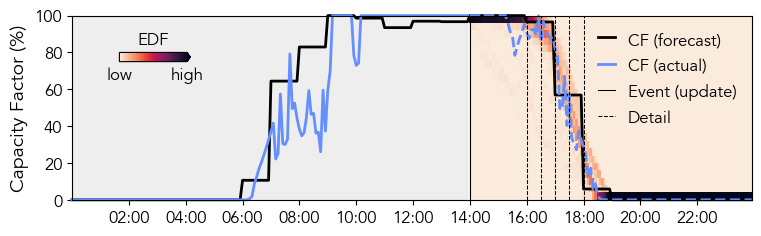

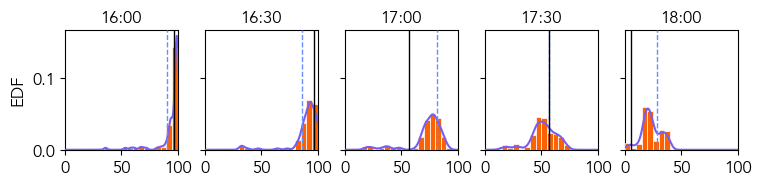

In [57]:
def _plot_histogram_cuts(_ax, M_, f_, e_, f_hat_, dx_, dt_, t, cuts_):

    tau_ = dt_[:t]
    s_ = dt_[t:]

    x_ = np.linspace(0, 100, 1000)[:, np.newaxis]

    for cut, i in zip(cuts_, range(len(cuts_))):
        _KD = KernelDensity(bandwidth=_silverman_rule(100 * M_[:, cut]),
                            algorithm="auto",
                            kernel="gaussian").fit(100 * M_[:, cut][:, np.newaxis])

        _ax[i].axvline(100 * f_hat_[cut],
                       color=palette_.loc[0, "ibm"],
                       lw=1,
                       ls="--",
                       label="CF (ac)",
                       zorder=10)

        _ax[i].axvline(100 * e_[t + cut], 
                       color="k", 
                       lw=1, 
                       label="CF (fc)", 
                       zorder=10)

        _ax[i].hist(100 * M_[:, cut],
                    bins=20,
                    range=(0, 100),
                    density=True,
                    color=palette_.loc[3, "ibm"], clip_on = True,
                    zorder=8, 
                    edgecolor='w', 
                    linewidth=.5)

        _ax[i].plot(x_, np.exp(_KD.score_samples(x_)),
                    label="KDE (update)",
                    color=palette_.loc[1, "ibm"],
                    lw=1.5,
                    zorder=9)

        _ax[i].set_title(dx_[t:][cut], size=12)
        _ax[i].set_xlim(0, 100)
        _ax[i].set_ylim(0,)
        
        #_ax[i].set_xlabel("Capacity Factor (%)", size=12)
        
        _ax[i].tick_params(axis="both",
                           labelsize=12)

    _ax[0].set_ylabel("EDF", size=12)

    # _ax[-1].legend(frameon=False, 
    #                fontsize=12)


def _plot_density_heatmap(_ax, M_, f_, e_, f_hat_, dx_, dt_, t, cuts_,
                         colorbar = True, legend = True):

    tau_ = dt_[:t]
    s_ = dt_[t:]

    Z_ = []
    for i in range(M_.shape[1]):
        a_, b_ = np.histogram(100.0 * M_[:, i], 
                              bins=25, 
                              range=(0, 100), 
                              density=True)
        Z_.append(a_)

    Z_ = np.stack(Z_).T
    X_, Y_ = np.meshgrid(dt_[t:], (b_[1:] + b_[:-1]) / 2.0)

    _cmap = sns.color_palette("rocket_r", as_cmap=True)
    _ax.pcolormesh(X_, Y_, Z_, cmap =_cmap)

    _ax.plot(dt_, 100 * e_, 
             c="k", 
             lw=2.0, 
             label="CF (forecast)", 
             clip_on=False)

    _ax.plot(tau_, 100 * f_,
             c=palette_.loc[0, "ibm"],
             clip_on=False,
             lw=2.0,
             label="CF (actual)")

    _ax.plot(s_, 100 * f_hat_, 
             c=palette_.loc[0, "ibm"], 
             clip_on=False, 
             lw=2.0, 
             ls="--")

    _ax.fill_between(tau_, 100 * np.ones(tau_.shape), 100 * np.zeros(tau_.shape),
                     color="lightgray",
                     alpha=0.375)

    _ax.axvline(dt_[t], 
                color="k", 
                linewidth=0.75, 
                label="Event (update)")

    _ax.axvline(dt_[t], 
                color="k", 
                lw=0.75, 
                ls="--", 
                label="Detail")

    for cut in cuts_:
        _ax.axvline(dt_[t + cut], 
                    color="k", 
                    lw=0.75, 
                    ls="--")

    _ax.set_xticks(dt_[24::24], dx_[24::24], rotation=0)
    _ax.set_ylabel("Capacity Factor (%)", size=14)

    _ax.tick_params(axis="both", labelsize=12)

    _ax.set_ylim(0.0, 100)
    _ax.set_xlim(dt_[0], dt_[-1])

    if legend:
        _ax.legend(frameon=False, 
                   loc='upper right',
                   fontsize=12, 
                   ncol=1)
        
    if colorbar:
        cbar = fig.colorbar(cm.ScalarMappable(cmap=_cmap),
                            cax=_ax.inset_axes([100, 75, 150, 5], transform=_ax.transData),
                            orientation="horizontal",
                            extend="max")
    
        cbar.set_ticks([0, 1], labels=["low", "high"], fontsize = 12)
        cbar.ax.tick_params(length=0)
    
        cbar.ax.set_title("EDF", rotation=0)

cuts_ = [24, 30, 36, 42, 48]

fig, _ax = plt.subplots(1, 1, 
                        figsize=(7.5, 2.25), 
                        layout="constrained")

_plot_density_heatmap(_ax, M_, f_, e_, f_hat_, dx_, dt_, t, cuts_)

plt.savefig(path_to_images + f"/EDF_heatmap_{file_name}.pdf", 
            bbox_inches="tight", 
            dpi=600)

plt.show()

fig, _ax = plt.subplots(1, len(cuts_), 
                        figsize=(7.5, 1.75), 
                        sharey=True, 
                        layout="constrained")

_plot_histogram_cuts(_ax, M_, f_, e_, f_hat_, dx_, dt_, t, cuts_)

plt.savefig(path_to_images + f"/marginal_density_cutoffs_{file_name}.pdf", 
            bbox_inches="tight", 
            dpi=600)

plt.show()

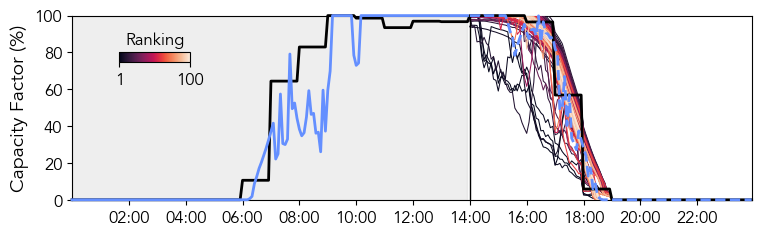

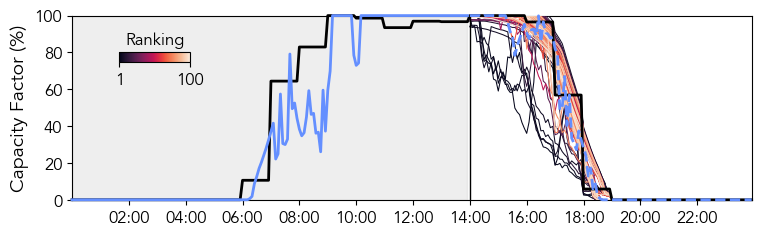

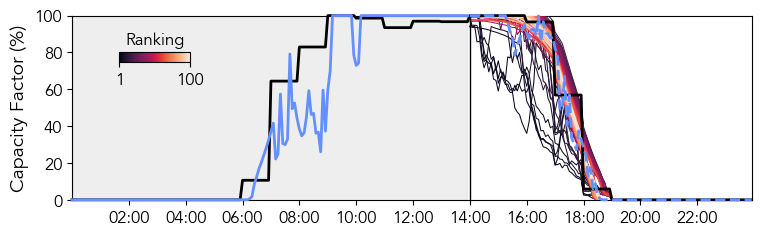

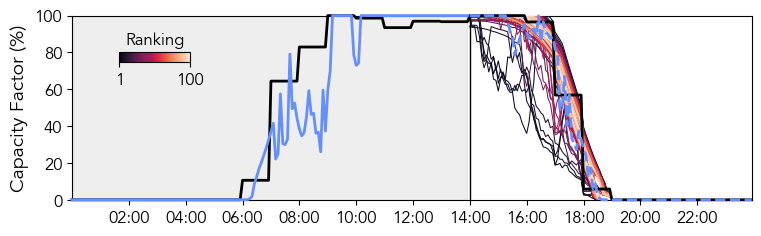

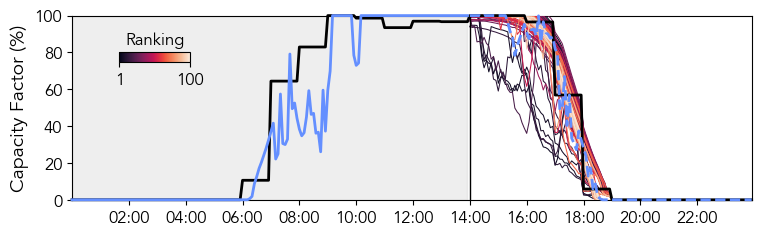

In [58]:
def _plot_depth(_fig, _ax, palette_, M_, f_, e_, f_hat_, w_, dx_, dt_, t, legend = True):

    tau_ = dt_[:t]
    s_   = dt_[t:]

    idx_ = np.argsort(w_)
    _cmap = sns.color_palette("rocket", as_cmap=True)
    _norm = plt.Normalize(0., 1)

    _ax.plot([], [], 
             label=r"$\hat{\mu}_i(s)$", 
             c="orange")

    for i in range(idx_.shape[0]):
        _ax.plot(dt_[t:], 100 * M_[idx_[i], :],
                 c=_cmap(_norm(i/idx_.shape[0])), 
                 lw=0.75, 
                 zorder=8)
        
    _ax.fill_between(tau_, 100 * np.ones(tau_.shape), 100 * np.zeros(tau_.shape),
                     color="lightgray",
                     alpha=0.375,
                     zorder=1)

    _ax.plot(tau_, 100.0 * f_,
             c=palette_.loc[0, "ibm"],
             zorder=10,
             label="CF (ac)",
             clip_on=False,
             lw=2)

    _ax.plot(s_, 100.0 * f_hat_,
             c=palette_.loc[0, "ibm"],
             zorder=10,
             lw=2,
             clip_on=False,
             ls="--")

    _ax.plot(dt_, 100.0 * e_, 
             lw=2, 
             zorder=9, 
             label="CF (fc)", 
             clip_on=False, 
             c="k")

    _ax.axvline(dt_[t], 
                color="k", 
                lw=1.0, 
                label="Event (update)", 
                zorder=8)
    
    _ax.set_xticks(dt_[24::24], dx_[24::24], rotation=0)
    # ax_[2].set_yticks(size = 12)
    _ax.set_ylim(0.0, 100.0)
    _ax.set_xlim(dt_[0], dt_[-1])
    _ax.set_ylabel("Capacity Factor (%)", size=14)
    
    _ax.tick_params(axis="both", 
                    labelsize=12)
    
    if legend:
        _ax.legend(frameon=False, 
                   fontsize=12, 
                   ncol=1)

    cbar = _fig.colorbar(cm.ScalarMappable(_norm, _cmap),
                         cax=_ax.inset_axes([100, 75, 150, 5], transform=_ax.transData),
                         orientation="horizontal")

    cbar.set_ticks([0, 1], 
                   labels=[1, M_.shape[0]], 
                   size=12)
        
    cbar.ax.set_title("Ranking", 
                      rotation=0, 
                      size=12)

fig, _ax = plt.subplots(1, 1, 
                        figsize=(7.5, 2.25), 
                        layout="constrained")


# Calculate functional depth ranking
depth = 'MBD'
d_ = _fDepth(M_, depth, path_to_fDepth).to_numpy()[:, 0]

_plot_depth(_fig, _ax, palette_, M_, f_, e_, f_hat_, d_, dx_, dt_, t, 
            legend = False)

plt.savefig(path_to_images + f"/{depth}_ranking_{file_name}.pdf", 
            bbox_inches="tight", 
            dpi=600)

plt.show()

fig, _ax = plt.subplots(1, 1, 
                        figsize=(7.5, 2.25), 
                        layout="constrained")

depth = 'DQ'
d_ = _fDepth(M_, depth, path_to_fDepth).to_numpy()[:, 0]

_plot_depth(_fig, _ax, palette_, M_, f_, e_, f_hat_, d_, dx_, dt_, t, 
            legend = False)

plt.savefig(path_to_images + f"/{depth}_ranking_{file_name}.pdf", 
            bbox_inches="tight", 
            dpi=600)

plt.show()


fig, _ax = plt.subplots(1, 1, 
                        figsize=(7.5, 2.25), 
                        layout="constrained")

depth = 'LD'
d_ = _fDepth(M_, depth, path_to_fDepth).to_numpy()[:, 0]

_plot_depth(_fig, _ax, palette_, M_, f_, e_, f_hat_, d_, dx_, dt_, t, 
            legend = False)

plt.savefig(path_to_images + f"/{depth}_ranking_{file_name}.pdf", 
            bbox_inches="tight", 
            dpi=600)

plt.show

fig, _ax = plt.subplots(1, 1, 
                        figsize=(7.5, 2.25), 
                        layout="constrained")

depth = 'ED'
d_ = _fDepth(M_, depth, path_to_fDepth).to_numpy()[:, 0]

_plot_depth(_fig, _ax, palette_, M_, f_, e_, f_hat_, d_, dx_, dt_, t, 
            legend = False)

plt.savefig(path_to_images + f"/{depth}_ranking_{file_name}.pdf", 
            bbox_inches="tight", 
            dpi=600)

plt.show()

fig, _ax = plt.subplots(1, 1, 
                        figsize=(7.5, 2.25), 
                        layout="constrained")

depth = 'ID'
d_ = _fDepth(M_, depth, path_to_fDepth).to_numpy()[:, 0]

_plot_depth(_fig, _ax, palette_, M_, f_, e_, f_hat_, d_, dx_, dt_, t, 
            legend = False)

plt.savefig(path_to_images + f"/{depth}_ranking_{file_name}.pdf", 
            bbox_inches="tight", 
            dpi=600)

plt.show()

10 (100, 120)
20 (100, 120)
30 (100, 120)
40 (100, 120)
10 (100, 120)
20 (100, 120)
30 (100, 120)
40 (100, 120)


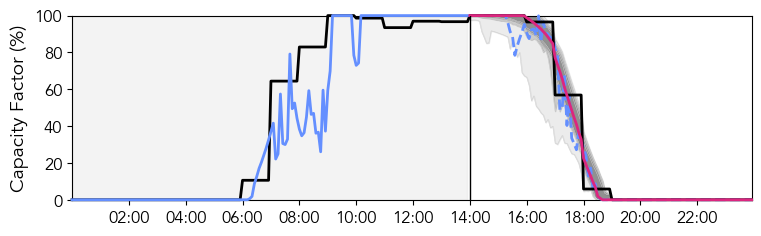

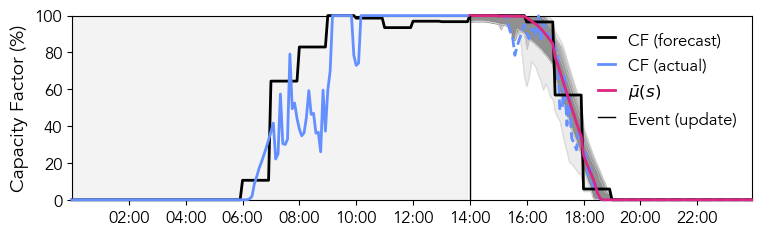

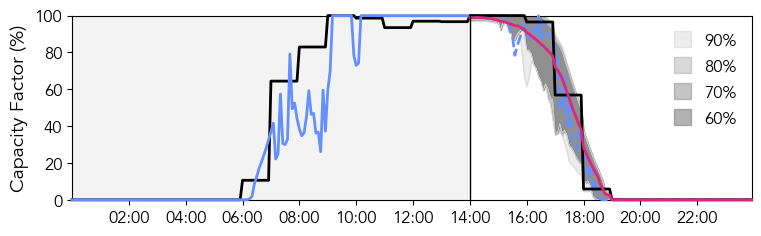

In [32]:
def _plot_envelop(_ax, _upper, _lower, f_, e_, f_hat_, m_, dt_, dx_, tau_, s_, t, 
                  labels_1 = True, 
                  labels_2 = True):

    s_p_ = np.concatenate([tau_[-1] * np.ones((1,)), s_], axis=0)

    _ax.plot(dt_, 100 * e_, 
             c="k", 
             lw=2.0, 
             label="CF (forecast)" if labels_1 else None, 
             zorder = 8,
             clip_on=False)

    _ax.plot(tau_, 100 * f_, 
            c       = palette_.loc[0, "ibm"], 
            label   = "CF (actual)" if labels_1 else None, 
            lw      = 2.0, 
            zorder = 8,
            clip_on = False)
    
    _ax.plot(s_, 100.0 * f_hat_, 
             c       = palette_.loc[0, "ibm"], 
             ls      = "--", 
             lw      = 2.0, 
             zorder = 7,
             clip_on = False)

    _ax.plot(s_, 100 * m_, 
            c       = palette_.loc[2, "ibm"], 
            label   = r"$\bar{\mu} (s)$" if labels_1 else None, 
            lw      = 2.0, 
            zorder  = 9,
            clip_on = False)
    
    _ax.axvline(dt_[t], 
                color     = "k", 
                linewidth = 1.0, 
                label     = "Event (update)" if labels_1 else None, 
                zorder    = 10)
    
    for key, i in zip(_upper.keys(), range(len(_upper.keys()))):

        upper_ = np.concatenate([f_, _upper[key]], axis=0)[f_.shape[0] - 1:]
        lower_ = np.concatenate([f_, _lower[key]], axis=0)[f_.shape[0] - 1:]

        _ax.plot(s_p_, 100. * upper_, 
                 lw = 0.375, 
                 c  = "lightgray")
        
        _ax.plot(s_p_, 100. * lower_, 
                 lw = 0.375, 
                 c  = "lightgray")

        alpha = float(key)
        ci    = int((1. - alpha)*100)
        
        _ax.fill_between(s_p_, 100. * upper_, 100. * lower_,
                        color  = "gray",
                        alpha  = 0.15 + i * 0.15,
                        label  = f"{ci}%" if labels_2 else None,
                        zorder = 1)
            
    _ax.fill_between(tau_, 100 * np.ones(tau_.shape), 100 * np.zeros(tau_.shape),
                     color = "lightgray",
                     alpha = 0.25)

    _ax.set_xticks(dt_[24::24], dx_[24::24], rotation=0)
    
    if labels_1 or labels_2: 
        _ax.legend(frameon  = False, 
                   loc = 'upper right',
                   #loc      = (0.0125, 0.1),
                   fontsize = 12,
                   ncol     = 1)
        
    _ax.tick_params(axis      = "both", 
                    labelsize = 12)
    
    _ax.set_ylim(0.0, 100)
    _ax.set_xlim(dt_[0], dt_[-1])
    _ax.set_ylabel("Capacity Factor (%)", size = 14)

    

alpha_ = [0.1, 0.2, 0.3, 0.4]

fig, _ax = plt.subplots(1, 1, 
                        figsize=(7.5, 2.25), 
                        layout="constrained")

# Calculate confidence intervals from functional depth metrics
m_, _upper, _lower = _confidence_intervals_from_eCDF(M_, alpha_)

_plot_envelop(_ax, _upper, _lower, f_, e_, f_hat_, m_, dt_, dx_, tau_, s_, t, 
              labels_1 = False, 
              labels_2 = False)

# _ax.set_title('EDF', 
#               loc = 'left',
#               fontsize = 18, 
#               y = 0.8, 
#               x = 0.0125)

plt.savefig(path_to_images + f"/EDF_envelop_{file_name}.pdf", 
            bbox_inches="tight", 
            dpi=600)

fig, _ax = plt.subplots(1, 1, 
                        figsize=(7.5, 2.25), 
                        layout="constrained")

# Calculate confidence intervals from Directional Quantiles
depth =  'LD'
m_, _upper, _lower = _confidence_intervals_from_fDepth(M_, alpha_, depth, path_to_fDepth)

_plot_envelop(_ax, _upper, _lower, f_, e_, f_hat_, m_, dt_, dx_, tau_, s_, t, 
              labels_1 = True, 
              labels_2 = False)

# _ax.set_title('Band Depth', 
#               loc = 'left', 
#               fontsize = 18, 
#               y = 0.8, 
#               x = 0.0125)

plt.savefig(path_to_images + f"/{depth}_envelop_{file_name}.pdf", 
            bbox_inches="tight", 
            dpi=600)

fig, _ax = plt.subplots(1, 1, 
                        figsize=(7.5, 2.25), 
                        layout="constrained")

# Calculate confidence intervals from the functional depth metric
depth = 'DQ'
m_, _upper, _lower = _confidence_intervals_from_fDepth(M_, alpha_, depth, path_to_fDepth)

_plot_envelop(_ax, _upper, _lower, f_, e_, f_hat_, m_, dt_, dx_, tau_, s_, t, 
              labels_1 = False, 
              labels_2 = True)

# _ax.set_title('L-inf', 
#               loc = 'left',
#               fontsize = 18, 
#               y = 0.8, 
#               x = 0.0125)

plt.savefig(path_to_images + f"/{depth}_envelop_{file_name}.pdf", 
            bbox_inches="tight", 
            dpi=600)

plt.show()

# Dynamic Forcasting Cone 

In [ ]:
def _empirical_interval_score(y_true, y_pred_lower, y_pred_upper, alpha):
    """
    Calculate the interval score for probabilistic forecasts with an interval [lower, upper].
    
    Parameters:
    - y_true: Observed (true) values
    - y_pred_upper: upper confidence interval for significance level alpha
    - y_pred_lower: low confidence interval for significance level alpha
    - alpha: Significance level (default 0.05 for 90% confidence interval)
    
    Returns:
    - interval_score: The calculated interval score
    """
        
    # Penalty for observation outside the lower bound
    penalty_lower = 2.*np.maximum(0, y_pred_lower - y_true)/alpha
    
    # Penalty for observation outside the upper bound
    penalty_upper = 2.*np.maximum(0, y_true - y_pred_upper)/alpha
    
    # Interval width penalty
    penalty_width = y_pred_upper - y_pred_lower
    
    # Total interval score
    return penalty_lower + penalty_upper + penalty_width

def _weighted_interval_score(y_true, y_pred, _y_pred_lower, _y_pred_upper, alpha_):
    """
    Calculate the interval score for probabilistic forecasts with an interval [lower, upper].
    
    Parameters:
    - y_true: Observed (true) values
    - _y_pred_lower: dictionary with upper confidence interval for all significance levels alpha
    - _y_pred_lower: dictionary with lower confidence interval for all significance levels alpha
    - alpha: all significance level alpha (default 0.05 for 90% confidence interval)

    Returns:
    - WIS: float, the Weighted Interval Score.
    """

    # Calculate the interval score
    w0  = 1/2.
    w_  = np.array(alpha_)/2.
    is_ = np.zeros((y_true.shape[0], w_.shape[0]))
    for i in range(len(alpha_)):
        is_[:, i] = _empirical_interval_score(y_true, 
                                              _y_pred_lower[f'{alpha_[i]}'],
                                              _y_pred_upper[f'{alpha_[i]}'], 
                                               alpha_[i])
    
    term0 = 1./(len(alpha_) + 1/2.)
    term1 = w0 * np.absolute(y_true - y_pred)

    for i in range(w_.shape[0]):
        is_[:, i] = w_[i] * is_[:, i]
    term2 = np.sum(is_, axis = 1)
        
    return term1 * (term1 + term2)

def _empirical_coverage_score(y_true, _lower, _upper, alpha_):
    """`
    Calculate the coverage score for probabilistic forecasts with an interval [lower, upper]
    
    Parameters:
    - y_: Observed (true) values
    - lower_: upper confidence bound
    - upper_: lower confidence dound
    
    Returns:
    - coverage_score: The calculated interval score
    """

    def _converage_score(y_true, lower_, upper_):
        coverage = 0
        for i in range(y_true.shape[0]): 
            if (y_true[i] < lower_[i]) or (y_true[i] > upper_[i]):
                coverage += 0
            else:
                coverage += 1
        return coverage / y_true.shape[0]


    cs_ = np.zeros((len(alpha_),))
    for i in range(len(alpha_)):
        cs_[i] = _converage_score(y_true, _lower[f'{alpha_[i]}'], _upper[f'{alpha_[i]}'])
    
    return cs_
    
# MBD_ = _modified_band_depth(M_)

alpha_ = [0.1, 0.2, 0.4]

# WIS_ = _weighted_interval_score(f_hat_, m_, _lower, _upper, alpha_)
# print(WIS_.mean())

# CS = _empirical_coverage_score(f_hat_, _lower, _upper, alpha_)
# print(CS)

# # Calculate confidence intervals from functional depth metrics
# m_, _upper, _lower = _confidence_intervals_from_MBD(M_, alpha_)
# print(m_.shape)

# # Calculate confidence intervals from functional depth metrics
# WIS_ = _weighted_interval_score(f_hat_, m_, _lower, _upper, alpha_)
# print(WIS_.mean())

# CS = _empirical_coverage_score(f_hat_, _lower, _upper, alpha_)
# print(CS)


In [ ]:
def _PIT_gaussian(y_true, forecast_mean, forecast_std, nbins=100):
    """
    Calculate the Probabilistic Integral Transform (PIT).

    Parameters:
    - y_true: Observed (true) values
    - forecast_mean: Mean of the predicted distribution (e.g., mean of the normal distribution)
    - forecast_std: Standard deviation of the predicted distribution

    Returns:
    - mean and std: The calculated PIT
    """

    u_samples = norm.cdf(y_true, loc=forecast_mean, scale=forecast_std)

    # Plot the histogram of U to check if it's uniformly distributed
    plt.figure(figsize=(12.5, 2.5))
    plt.hist(
        u_samples,
        bins=nbins,
        density=True,
        alpha=0.7,
        color="blue",
        label="Transformed (U)",
    )

    plt.hlines(1, 0, 1, color="red", linestyle="--", label="Uniform distribution")

    plt.title("Probabilistic Integral Transform")
    plt.xlabel("U")
    plt.ylabel("PDF")
    plt.legend()


def _PIT(z_, nbins=100, file_name="unnamed.png"):
    """
    Calculate the Probabilistic Integral Transform (PIT).

    Parameters:
    - z_: CDF evaluations
    - nbins: number of bins in the histogram
    """

    # Plot the histogram of U to check if it's uniformly distributed
    plt.figure(figsize=(5, 2.5))
    plt.hist(
        z_, bins=nbins, density=True, alpha=0.7, color="blue", label="Transformed (U)"
    )

    plt.hlines(1, 0, 1, color="red", linestyle="--", label="Uniform distribution")
    plt.ylim(
        0.0,
        2,
    )

    plt.title("Probabilistic Integral Transform")
    plt.xlabel("U")
    plt.ylabel("PDF")
    plt.legend()

    plt.savefig(path_to_images + r"/{}".format(file_name), bbox_inches="tight", dpi=300)


def _KS(z_, nbins=100):
    """
    Calculate the Kolmogorov–Smirnov (KS) statistic for a normal dist.

    Parameters:
    - y_true: Observed (true) values
    - forecast_mean: Mean of the predicted distribution (e.g., mean of the normal distribution)
    - forecast_std: Standard deviation of the predicted distribution

    Returns:
    - sup_ks: Kolmogorov–Smirnov statistic
    - avg_ks: Kolmogorov–Smirnov statistic but calculating RMSE instead of sup

    """

    # u_samples_  = norm.cdf(y_true, loc = forecast_mean, scale = forecast_std)
    hist_, bin_ = np.histogram(z_, nbins, density=True)
    bins_ = (bin_[:-1] + bin_[1:]) / 2.0
    # r_ = np.cumsum(hist_) - np.cumsum(np.ones(bins_.shape))

    plt.figure()
    plt.plot(np.cumsum(hist_))
    plt.plot(np.cumsum(np.ones(bins_.shape)))
    plt.show()

    # avg_ks = np.sqrt(np.mean((np.cumsum(hist_) - np.cumsum(np.ones(bins_.shape)))**2))/hist_.shape[0]
    sup_ks = np.max(np.absolute(np.cumsum(hist_) - np.cumsum(np.ones(bins_.shape))))

    return sup_ks

In [ ]:
t = 144
forget_rate = 2
n_kNNs = 500
i = 48
z_1_ = []

for a in range(20):
    print(a)
    for d in range(365):

        F_tr_, F_ts_, F_hat_tr_, F_hat_ts_, f_tr_, f_ts_ = _get_test_sample(
            F_ac_tr_, F_ac_ts_, F_fc_ts_p_, p_, a, d, t
        )

        f_fc_ts_ = F_fc_ts_[d, t:, a]
        f_fc_tr_ = F_fc_ts_[d, :t, a]

        _model = _fit(F_tr_, F_ts_, forget_rate=forget_rate, n_kNNs=n_kNNs)

        _model = _predict(_model, F_hat_ts_, f_tr_)

        # for i in range(48):
        _eCDF = ECDF(_model["F_"][:, i])
        if _eCDF(f_ts_[i]) == 1.0:
            continue
        else:
            # z_.append(_eCDF(f_fc_ts_[i] - f_ts_[i]))
            z_1_.append(_eCDF(f_ts_[i]))

In [ ]:
_PIT(
    np.stack(z_1_),
    nbins=10,
    file_name="{}_{}_{}-PIT-48.png".format(t, forget_rate, n_kNNs),
)
_KS(np.stack(z_1_), nbins=100)

In [ ]:
t = 144
forget_rate = 2
n_kNNs = 500
i = 24

z_2_ = []

for a in range(20):
    print(a)
    for d in range(365):

        F_tr_, F_ts_, F_hat_tr_, F_hat_ts_, f_tr_, f_ts_ = _get_test_sample(
            F_ac_tr_, F_ac_ts_, F_fc_ts_p_, p_, a, d, t
        )

        #         f_fc_ts_ = F_fc_ts_[d, t:, a]
        #         f_fc_tr_ = F_fc_ts_[d, :t, a]

        _model = _fit(F_tr_, F_ts_, forget_rate=forget_rate, n_kNNs=n_kNNs)

        _model = _predict(_model, F_hat_ts_, f_tr_)

        # for i in range(48):
        _eCDF = ECDF(_model["F_"][:, i])
        if (_eCDF(f_ts_[i]) == 0.0) | (_eCDF(f_ts_[i]) == 1.0):
            continue
        else:
            # z_.append(_eCDF(f_fc_ts_[i] - f_ts_[i]))
            z_2_.append(_eCDF(f_ts_[i]))

In [ ]:
_PIT(
    np.stack(z_2_),
    nbins=10,
    file_name="{}_{}_{}-PIT-24.png".format(t, forget_rate, n_kNNs),
)
_KS(np.stack(z_2_), nbins=100)

In [ ]:
t = 144
forget_rate = 2
n_kNNs = 500
i = 12
z_3_ = []

for a in range(20):
    print(a)
    for d in range(365):

        F_tr_, F_ts_, F_hat_tr_, F_hat_ts_, f_tr_, f_ts_ = _get_test_sample(
            F_ac_tr_, F_ac_ts_, F_fc_ts_p_, p_, a, d, t
        )

        # f_fc_ts_ = F_fc_ts_[d, t:, a]
        # f_fc_tr_ = F_fc_ts_[d, :t, a]

        _model = _fit(F_tr_, F_ts_, forget_rate=forget_rate, n_kNNs=n_kNNs)

        _model = _predict(_model, F_hat_ts_, f_tr_)

        # for i in range(48):
        _eCDF = ECDF(_model["F_"][:, i])
        if _eCDF(f_ts_[i]) == 1.0:
            continue
        else:
            # z_.append(_eCDF(f_fc_ts_[i] - f_ts_[i]))
            z_3_.append(_eCDF(f_ts_[i]))

In [ ]:
_PIT(
    np.stack(z_3_),
    nbins=10,
    file_name="{}_{}_{}-PIT-12.png".format(t, forget_rate, n_kNNs),
)
_KS(np.stack(z_3_), nbins=100)

In [ ]:
t = 144
forget_rate = 2
n_kNNs = 500

i = 60
z_4_ = []

for a in range(20):
    print(a)
    for d in range(365):

        F_tr_, F_ts_, F_hat_tr_, F_hat_ts_, f_tr_, f_ts_ = _get_test_sample(
            F_ac_tr_, F_ac_ts_, F_fc_ts_p_, p_, a, d, t
        )

        # f_fc_ts_ = F_fc_ts_[d, t:, a]
        # f_fc_tr_ = F_fc_ts_[d, :t, a]

        _model = _fit(F_tr_, F_ts_, forget_rate=forget_rate, n_kNNs=n_kNNs)

        _model = _predict(_model, F_hat_ts_, f_tr_)

        # for i in range(36):
        _eCDF = ECDF(_model["F_"][:, i])
        if _eCDF(f_ts_[i]) == 1.0:
            continue
        else:
            # z_.append(_eCDF(f_fc_ts_[i] - f_ts_[i]))
            z_4_.append(_eCDF(f_ts_[i]))

In [ ]:
_PIT(
    np.stack(z_4_),
    nbins=10,
    file_name="{}_{}_{}-PIT-60.png".format(t, forget_rate, n_kNNs),
)
_KS(np.stack(z_4_), nbins=100)

In [ ]:
# # Forecast dynamic update based on distance
# def _ffc_predict(_model, f_, fc_):

#     F_ = _model['F_tr_']

#     # Smoothing observed mean and actuals
#     if (_model['smoothing'] == 1) | (_model['smoothing'] == 3):
#         F_, f_ = _smoothing(F_, f_, _model['lambda'])

#     # phi: importance weights based on time distance
#     phi_ = _exponential_decay_minus(f_.shape[0], _model['forget_rate'])

#     # plt.figure(figsize = (10, 2))
#     # plt.title('Forget Rate')
#     # plt.plot(phi_)
#     # plt.ylim(-0.1,1.1)
#     # plt.show()

#     # d: euclidian distance between samples weighted by importance weights (phi)
#     d_ = _dist(F_, f_, phi_/phi_.sum())
#     # w: normalized wieghts distance across observations based on RBF kernel distance
#     w_ = _kernel(d_, _model['length_scale'])

#     _model['weights'] = w_/w_.sum()

#     # Multivariate normal assumption
#     _model = _predictive_multivariate_normal_dist(_model, fc_)

#     return _model

# Multivariate normal forecast assumption
# def _predictive_multivariate_normal_dist(_model, fc_):

#     F_ = _model['F_ts_']
#     w_ = _model['weights']

#     # Mean function
#     f_hat_ = F_.T @ w_

#     # Regulate mean function
#     f_hat_ = _gen_constraint(f_hat_, _model['f_min'], _model['f_max'])

#     # Smoothing prediction: unobserved mean and actuals
#     if (_model['smoothing'] == 2) | (_model['smoothing'] == 3):
#         F_, f_hat_ = _smoothing(F_, f_hat_, _model['lambda'])

#     # Fuse day-ahead forecast with real-time forecast
#     mu_hat_ = _update_forecast(F_, f_hat_, fc_, _model['trust_rate'])

#     # Covariance function
#     F_hat_ = np.repeat(mu_hat_[:, np.newaxis], F_.shape[0], axis = 1).T
#     S_hat_ = (F_ - F_hat_).T @ np.diag(w_) @ (F_ - F_hat_)

#     # plt.figure(figsize = (10, 2))
#     # plt.plot(f_hat_, label = 'real-time (fc)')
#     # plt.plot(fc_, label = 'day-ahead (fc)')
#     # plt.plot(mu_hat_, label = 'update (fc)')
#     # plt.ylim(-0.1,)
#     # plt.legend()
#     # plt.show()

#     # Define probability dist
#     _N = multivariate_normal(mu_hat_, S_hat_, allow_singular = True)

#     _model['normal'] = {}
#     _model['normal']['mean']         = mu_hat_
#     _model['normal']['covariance']   = S_hat_
#     _model['normal']['distribution'] = _N

#     return _model.copy()

In [ ]:
# def _fneighborhood_v0(d_f_, d_e_, w_f_, w_e_, w_, idx_0_, idx_1_, idx_2_, xi):

#     #_cmap = plt.get_cmap('gnuplot')
#     _cmap = sns.color_palette("rocket_r", as_cmap = True)
#     _norm = plt.Normalize(w_.min(), w_.max())

#     fig, ax_ = plt.subplots(1, 3,
#                             figsize = (15, 5),
#                             layout  = 'constrained')

#     ax_[0].plot(d_f_[np.argsort(d_f_)], w_f_[np.argsort(d_f_)],
#                 c     = palette_.loc[0, 'ibm'],
#                 label = 'f')
#     ax_[0].plot(d_e_[np.argsort(d_e_)], w_e_[np.argsort(d_e_)],
#                 c     = palette_.loc[3, 'ibm'],
#                 label = 'e')

#     ax_[0].axhline(xi,
#                    color  = 'k',
#                    lw     = 1.,
#                    label  = r'$\xi$',
#                    zorder = 10)

#     ax_[0].set_ylabel(r'$\varphi_{\lambda} (r)$', size = 14)
#     ax_[0].set_xlabel(r'$r$', size = 14)

#     ax_[0].tick_params(axis      = 'both',
#                        labelsize = 12)

#     ax_[0].legend(frameon = False)
#     #plt.xlim(0, 1)
#     #plt.ylim(0, 1)

#     ax_[1].scatter(w_f_, w_e_,
#                    c     = _cmap(_norm(w_)),
#                    s     = 1.,
#                    alpha = 0.5)

#     ax_[1].set_ylabel(r'$\varphi_{\lambda_e} (r_{e})$', size = 14)
#     ax_[1].set_xlabel(r'$\varphi_{\lambda_f} (r_{f})$', size = 14)
#     ax_[1].tick_params(axis      = 'both',
#                        labelsize = 12)
#     #plt.xlim(0, 1)
#     #plt.ylim(0, 1)

# #     ax_[2].scatter(w_f_, w_e_, c = 'gray',
# #                                s = 1.,
# #                                alpha = .5)

# #     ax_[2].scatter(w_f_[idx_1_], w_e_[idx_1_], c = palette_.loc[3, 'imb'],
# #                                                s = 1,
# #                                                alpha = .5)

# #     ax_[2].set_ylabel(r'$\varphi_{\lambda_e} (r_{e})$', size = 14)
# #     ax_[2].set_xlabel(r'$\varphi_{\lambda_f} (r_{f})$', size = 14)
# #     ax_[2].tick_params(axis = 'both', labelsize = 12)

#     ax_[2].scatter(w_f_, w_e_,
#                    c     = 'gray',
#                    s     = 15.,
#                    alpha = 1.,
#                    lw    = .125,
#                    ec    = 'k')

#     ax_[2].scatter(w_f_[idx_1_], w_e_[idx_1_],
#                    c     = palette_.loc[0, 'ibm'],
#                    s     = 15,
#                    alpha = 1.,
#                    lw    = .125,
#                    ec    = 'k')

#     c_ = [palette_.loc[2, 'ibm'], palette_.loc[4, 'ibm']]
#     for i, j in zip(idx_2_, idx_0_[idx_2_]):
#         ax_[2].scatter(w_f_[i], w_e_[i],
#                        c     = c_[j],
#                        s     = 25,
#                        lw    = .25,
#                        ec    = 'k',
#                        alpha = 1.)

#     ax_[2].axline((1, 1), slope = 1,
#                           lw    = 1,
#                           c     = 'k')

#     ax_[2].set_ylabel(r'$\varphi_{\lambda_e} (r_{e})$', size = 14)
#     ax_[2].set_xlabel(r'$\varphi_{\lambda_f} (r_{f})$', size = 14)

#     ax_[2].tick_params(axis      = 'both',
#                        labelsize = 12)

#     ax_[2].set_xlim(w_f_[idx_2_].min()*0.9985, w_f_[idx_2_].max()*1.0015)
#     ax_[2].set_ylim(w_e_[idx_2_].min()*0.9985, w_e_[idx_2_].max()*1.0015)

#     plt.savefig(path_to_images + r'/fneighbor.pdf',
#                 bbox_inches = 'tight',
#                 dpi         = 300)

#     plt.show()